# Automated Extraction of Medical Risk Factors For Life Insurance Underwriting
 
Life insurance underwriting considers an applicant’s medical risk factors, usually provided inside free-text documents. New insurance-specific Natural Language Processing (NLP) models can automatically extract material medical history and risk factors from such documents. This joint Solution Accelerator with John Snow Labs makes it easy to implement this in practice – enabling a faster, more consistent, and more scalable underwriting experience. This tutorial will cover:
- The end-to-end solution architecture on Databricks, from data ingestion to dashboarding
- Easily analyze free-text documents to extract medical history & risk factors using NLP
- Executable Python notebooks implementing the solution that you can start from today

## 0. Insurance Risk Factors

In this tutorial, we will get the following list of medical risk factors from unstructured clinical notes using Spark NLP models and tools and make analysis on the results.<br><br>


- **Basic Profile**
    - ✅ Age 
    - ✅ Gender 
    - ✅ Weight 
    - ✅ Height
    - ✅ Race/Ethnicity
    - ✅ Disability
- **Personal History**
    - ✅ Medical records (ICD-10-CM)
    - ✅ Prescription history (RxNorm) 
    - ✅ Actions of prescriptions (Action Mapper)
    - ✅ Family health history (ICD-10-CM + Assertion)
    - *Criminal history (Excluded - receive from authorities)*
    - *Driving history (Excluded - receive from authorities)*
- **Lifestyle**
    - ✅ Profession
    - ✅ Marital status
    - ✅ Housing
    - ✅ Smoking 
    - ✅ Alcohol 
    - ✅ Substance 
- **Diseases**
    - ✅ Asthma and breathing problems
    - ✅ Heart disease, including heart attacks and angina
    - ✅ High cholesterol
    - ✅ High blood pressure
    - ✅ Hypertension
    - ✅ Cancer
    - ✅ Strokes, including mini-strokes and brain haemorrage
    - ✅ Anxiety
    - ✅ Depression
    - ✅ Diabetes
    - ✅ Obesity
    - ✅ Epilepsy
    - ✅ Cerebral palsy and other neurological conditions
    - ✅ Kidney diseases

## 1. Initial Configurations

In [0]:
import json
import os
import string
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import combinations

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml import Pipeline, PipelineModel

import sparknlp
import sparknlp_jsl
from sparknlp.base import *
from sparknlp.util import *
from sparknlp.annotator import *
from sparknlp_jsl.base import *
from sparknlp_jsl.annotator import *
from sparknlp.pretrained import ResourceDownloader

pd.set_option("display.max_colwidth",0)
pd.set_option("display.max_columns",0)
pd.set_option("display.expand_frame_repr", False)

spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.0 
 Master 
 spark://10.139.64.6:7077 
 AppName 
 Databricks Shell

## 2. Helper Functions

We will define some helper functions to use in downstreaming tasks.

In [0]:
def get_resolver_code(light_pipeline, text, output_col):
    # returns resolutions and codes
    res = light_pipeline.fullAnnotate(text)[0][output_col][0]
    res_code = res.result
    resolution = res.metadata['resolved_text']
    return res_code, resolution

In [0]:
def get_treatment_action(drug_rxnorm):
    # returns RxNorm codes and drug actions
    try:
        action = mapper_lp.fullAnnotate(drug_rxnorm[0])[0]['action'][0].result
    except: 
        action = "NONE"
    return (drug_rxnorm[1], action)

In [0]:
def get_occurence(df, label, pair_count):
    # returns the counts of the term occurence 
    d  = Counter()
    a = df[label].to_list()
    for sub in a:
        if len(a) < pair_count:
            continue
        sub.sort()
        for comb in combinations(sub, pair_count):
            d[comb] += 1
    return d

In [0]:
def get_normalized_name(df, column):
    # returns the normalized terms only
    normalized_names = []
    for i in df[column]:
        if len(i)>0:
            tmp_list = [j[1] for j in i]
        else:
            tmp_list = i
        normalized_names.append(tmp_list)
    return normalized_names

## 3. Download Clinical Notes

First we will create our folders and then download sample clinical notes.

In this notebook we will use the slightly modified version of transcribed medical reports in [www.mtsamples.com](www.mtsamples.com). 

You can download those reports by the script [here](https://github.com/JohnSnowLabs/spark-nlp-workshop/blob/master/databricks/python/healthcare_case_studies/mt_scrapper.py).

In [0]:
# create folders
dbutils.fs.mkdirs("dbfs:/databricks/driver/Insurence_Risk_Factors")
dbutils.fs.mkdirs("dbfs:/databricks/driver/Insurence_Risk_Factors/data")
dbutils.fs.mkdirs("dbfs:/databricks/driver/Insurence_Risk_Factors/results")

Out[49]: True

In [0]:
#download dataset
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/healthcare-nlp/data/mt_data.csv -P /dbfs/databricks/driver/Insurence_Risk_Factors/data

In [0]:
# read data as a pandas dataframe
data = pd.read_csv('/dbfs/databricks/driver/Insurence_Risk_Factors/data/mt_data.csv')
data.head()

PATIENT_ID 
 medical_speciality 
 file_name 
 text 
 
 
 
 
 0 
 #93810 
 Bariatrics 
 Bariatrics_00.txt 
 Medical Specialty:Bariatrics\nSample Name:Bariatric Consult - Surgical Weight Loss - 1\nDescription:Evaluation for elective surgical weight loss via the gastric bypass as opposed to Lap-Band.\n(Medical Transcription Sample Report)\nThe patient was seen in my office for evaluation for elective surgical weight loss on October 6, 2008. She is a 34-year-old female with a BMI of 43. She is 5'6" tall and weighs 267 pounds. She is motivated to attempt surgical weight loss because she has been overweight for many years and wants to have more energy and improve her self-image. She is not only affected physically, but also socially by her weight. When she loses weight she always regains it and she always gains back more weight than she has lost. At one time, she lost 100 pounds and gained the weight back within a year. She has tried numerous commercial weight loss programs including Weight Watcher's for four months in 1992 with 15-pound weight loss, Slim Fast for six weeks in 2004 with eight-pound weight loss, an exercise program for two months in 2007 with a five-pound weight loss, Atkin's Diet for three months in 2008 with a ten-pound weight loss, and Dexatrim for one month in 2005 with a five-pound weight loss. She has also tried numerous fat reduction or fad diets. She was on Redux for nine months with a 100-pound weight loss.\nPAST MEDICAL HISTORY: She has a history of hypertension and tachycardia.\nPAST SURGICAL HISTORY: Pertinent for cholecystectomy.\nPSYCHOLOGICAL HISTORY: Negative.\nSOCIAL HISTORY: She is single. She drinks alcohol once a week. She does not smoke.\nFAMILY HISTORY: Pertinent for obesity and hypertension.\nMEDICATIONS: Include Topamax 100 mg twice daily, Zoloft 100 mg twice daily, Abilify 5 mg daily, Motrin 800 mg daily, and a multivitamin.\nALLERGIES: She has no known allergies.\nREVIEW OF SYSTEMS: Negative.\nPHYSICAL EXAM: This is a pleasant female in no acute distress. Alert and oriented x 3. \nHEENT: Normocephalic, atraumatic. Extraocular muscles intact, nonicteric sclerae. Chest is clear to auscultation bilaterally. Cardiovascular is normal sinus rhythm. Abdomen is obese, soft, nontender and nondistended. Extremities show no edema, clubbing or cyanosis.\nASSESSMENT/PLAN: This is a 34-year-old female with a BMI of 43 who is interested in surgical weight via the gastric bypass as opposed to Lap-Band. She will be asking for a letter of medical necessity from Dr. XYZ. She will also see my nutritionist and social worker and have an upper endoscopy. Once this is completed, we will submit her to her insurance company for approval.\n 
 
 
 1 
 #24592 
 Bariatrics 
 Bariatrics_01.txt 
 \nMedical Specialty:Bariatrics\nSample Name: Bariatric Consult - Surgical Weight Loss - 2\nDescription: Evaluation for elective surgical weight loss via the Lap-Band as opposed to gastric bypass.\n(Medical Transcription Sample Report)\nABC was seen in my office on October 6, 2008 for evaluation for elective surgical weight loss. ABC is a 51-year-old female with a BMI today of 43. She is 5'4" tall and weighs 252 pounds. She is motivated to attempt surgical weight loss because she has been overweight for over 20 years and wants to lose weight slowly and be more active with her grandchildren and be healthier. She is mainly affected physically by her weight. When she loses weight she always regains it and she always gains back more weight than she has lost. At one time, she lost 25 pounds and gained the weight back in about six months. She has done numerous commercial weight loss programs including Weight Watcher's for six months in 1997, 1999, 2002, and 2004 with a 10 to 25-pound weight loss, TOPS Program in 1998 with a ten-pound weight loss, hypnosis for four months in 1988 with a 20-pound weight loss, an exercise program for two months in 2008 with six-pound weight loss, and Six Week Body Makeover for one month in 2008 with a two-p

In [0]:
data.shape

Out[13]: (5009, 4)

In [0]:
# list of medical specialities in data
[i for i in data.medical_speciality.unique()]

Out[14]: ['Bariatrics',
 'Cardiovascular_Pulmonary',
 'Endocrinology',
 'General_Medicine',
 'Hematology_Oncology',
 'Nephrology',
 'Neurology',
 'Obstetrics_Gynecology',
 'Psychiatry_Psychology',
 'Radiology',
 'Allergy_Immunology',
 'Autopsy',
 'Chiropractic',
 'Consult_History_and_Phy.',
 'Cosmetic_Plastic_Surgery',
 'Dentistry',
 'Dermatology',
 'Diets_and_Nutritions',
 'Discharge_Summary',
 'ENT_Otolaryngology',
 'Emergency_Room_Reports',
 'Gastroenterology',
 'Hospice_Palliative_Care',
 'IME',
 'Lab_Medicine_Pathology',
 'Letters',
 'Neurosurgery',
 'Office_Notes',
 'Ophthalmology',
 'Orthopedic',
 'Pain_Management',
 'Pediatrics_Neonatal',
 'Physical_Medicine_Rehab',
 'Podiatry',
 'Rheumatology',
 'SOAP_Chart_Progress_Notes',
 'Sleep_Medicine',
 'Speech_Language',
 'Surgery',
 'Urology']

**We will choose some of the most related medical specialities that can be used in our insurance risk factor task.**

In [0]:
risky_diseases = ['Bariatrics', 'Cardiovascular_Pulmonary', 'Hematology_Oncology', 'General_Medicine', 'Neurology', 'Nephrology', 'Obstetrics_Gynecology', 'Psychiatry_Psychology', 'Radiology', 'Endocrinology']
data = data[data.medical_speciality.isin(risky_diseases)].reset_index(drop=True)

**Now we will get one clinical note sample from each medical speciality and work on this data.**

In [0]:
df_samples = pd.DataFrame()
for a, group in data.groupby('medical_speciality'):
    df_samples = pd.concat([df_samples, group.head(1)], ignore_index=True)

df_samples

PATIENT_ID 
 medical_speciality 
 file_name 
 text 
 
 
 
 
 0 
 #93810 
 Bariatrics 
 Bariatrics_00.txt 
 Medical Specialty:Bariatrics\nSample Name:Bariatric Consult - Surgical Weight Loss - 1\nDescription:Evaluation for elective surgical weight loss via the gastric bypass as opposed to Lap-Band.\n(Medical Transcription Sample Report)\nThe patient was seen in my office for evaluation for elective surgical weight loss on October 6, 2008. She is a 34-year-old female with a BMI of 43. She is 5'6" tall and weighs 267 pounds. She is motivated to attempt surgical weight loss because she has been overweight for many years and wants to have more energy and improve her self-image. She is not only affected physically, but also socially by her weight. When she loses weight she always regains it and she always gains back more weight than she has lost. At one time, she lost 100 pounds and gained the weight back within a year. She has tried numerous commercial weight loss programs including Weight Watcher's for four months in 1992 with 15-pound weight loss, Slim Fast for six weeks in 2004 with eight-pound weight loss, an exercise program for two months in 2007 with a five-pound weight loss, Atkin's Diet for three months in 2008 with a ten-pound weight loss, and Dexatrim for one month in 2005 with a five-pound weight loss. She has also tried numerous fat reduction or fad diets. She was on Redux for nine months with a 100-pound weight loss.\nPAST MEDICAL HISTORY: She has a history of hypertension and tachycardia.\nPAST SURGICAL HISTORY: Pertinent for cholecystectomy.\nPSYCHOLOGICAL HISTORY: Negative.\nSOCIAL HISTORY: She is single. She drinks alcohol once a week. She does not smoke.\nFAMILY HISTORY: Pertinent for obesity and hypertension.\nMEDICATIONS: Include Topamax 100 mg twice daily, Zoloft 100 mg twice daily, Abilify 5 mg daily, Motrin 800 mg daily, and a multivitamin.\nALLERGIES: She has no known allergies.\nREVIEW OF SYSTEMS: Negative.\nPHYSICAL EXAM: This is a pleasant female in no acute distress. Alert and oriented x 3. \nHEENT: Normocephalic, atraumatic. Extraocular muscles intact, nonicteric sclerae. Chest is clear to auscultation bilaterally. Cardiovascular is normal sinus rhythm. Abdomen is obese, soft, nontender and nondistended. Extremities show no edema, clubbing or cyanosis.\nASSESSMENT/PLAN: This is a 34-year-old female with a BMI of 43 who is interested in surgical weight via the gastric bypass as opposed to Lap-Band. She will be asking for a letter of medical necessity from Dr. XYZ. She will also see my nutritionist and social worker and have an upper endoscopy. Once this is completed, we will submit her to her insurance company for approval.\n 
 
 
 1 
 #76237 
 Cardiovascular_Pulmonary 
 Cardiovascular_Pulmonary_00.txt 
 Medical Specialty:Cardiovascular / Pulmonary\nSample Name: 2-D Doppler\nDescription: Normal left ventricle, moderate biatrial enlargement, and mild tricuspid regurgitation, but only mild increase in right heart pressures.\n(Medical Transcription Sample Report)\n2-D STUDY\n1. Mild aortic stenosis, widely calcified, minimally restricted.\n2. Mild left ventricular hypertrophy but normal systolic function.\n3. Moderate biatrial enlargement.\n4. Normal right ventricle.\n5. Normal appearance of the tricuspid and mitral valves.\n6. Normal left ventricle and left ventricular systolic function.\nDOPPLER\n1. There is 1 to 2+ aortic regurgitation easily seen, but no aortic stenosis.\n2. Mild tricuspid regurgitation with only mild increase in right heart pressures, 30-35 mmHg maximum.\nSUMMARY\n1. Normal left ventricle.\n2. Moderate biatrial enlargement.\n3. Mild tricuspid regurgitation, but only mild increase in right heart pressures. 
 
 
 2 
 #46930 
 Endocrinology 
 Endocrinology_00.txt 
 \nMedical Specialty:Endocrinology\nSample Name: Acquired Hypothyroidism Followup\nDescription: Return visit to the endocrine clinic for acquired hypothyroidism, papillary carcinoma of the thyroid gland status post total thyroi

In [0]:
# create spark dataframe 
df = spark.createDataFrame(df_samples)
df.show()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:626: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  [(c, t) for (_, c), t in zip(pdf_slice.iteritems(), arrow_types)]
+----------+--------------------+--------------------+--------------------+
|PATIENT_ID|  medical_speciality|           file_name|                text|
+----------+--------------------+--------------------+--------------------+
|    #93810|          Bariatrics|   Bariatrics_00.txt|Medical Specialty...|
|    #76237|Cardiovascular_Pu...|Cardiovascular_Pu...|Medical Specialty...|
|    #46930|       Endocrinology|Endocrinology_00.txt|\nMedical Special...|
|    #93507|    General_Medicine|General_Medicine_...|\nMedical Special...|
|    #73654| Hematology_Oncology|Hematology_Oncolo...|Medical Specialty...|
|    #66148|          Nephrology|   Nephrology_00.txt|Medical Specialty...|
|    #82140|           Neurology|    Neurology_00.txt|\nMedical Special...|
|    #821

## 4. Setup Initial NLP Pipeline Stages

In [0]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sentenceDetector = SentenceDetectorDLModel.pretrained("sentence_detector_dl_healthcare","en","clinical/models") \
  .setInputCols(["document"]) \
  .setOutputCol("sentence")

tokenizer = Tokenizer()\
  .setInputCols(["sentence"])\
  .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")

sentence_detector_dl_healthcare download started this may take some time.
Approximate size to download 367.3 KB
[OK!]
embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]


## 5. Risk Factor Extraction

We will download the `sparknlp_jsl` NER models and whitelist the labels that can be used as insurance risk factor.

Lets check the NER labels in `ner_jsl` model and whitelist the ones that are most related to our case. You can add other labels or remove some of them by editting the whitelist.

In [0]:
jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_jsl")\
    .setLabelCasing('upper')

ner_jsl download started this may take some time.
[OK!]


In [0]:
# ner_jsl labels

set([i.split("-")[1] for i in jsl_ner.getClasses() if i != "O"])

Out[20]: {'Admission_Discharge',
 'Age',
 'Alcohol',
 'Allergen',
 'BMI',
 'Birth_Entity',
 'Blood_Pressure',
 'Cerebrovascular_Disease',
 'Clinical_Dept',
 'Communicable_Disease',
 'Date',
 'Death_Entity',
 'Diabetes',
 'Diet',
 'Direction',
 'Disease_Syndrome_Disorder',
 'Dosage',
 'Drug_BrandName',
 'Drug_Ingredient',
 'Duration',
 'EKG_Findings',
 'Employment',
 'External_body_part_or_region',
 'Family_History_Header',
 'Fetus_NewBorn',
 'Form',
 'Frequency',
 'Gender',
 'HDL',
 'Heart_Disease',
 'Height',
 'Hyperlipidemia',
 'Hypertension',
 'ImagingFindings',
 'Imaging_Technique',
 'Injury_or_Poisoning',
 'Internal_organ_or_component',
 'Kidney_Disease',
 'LDL',
 'Labour_Delivery',
 'Medical_Device',
 'Medical_History_Header',
 'Modifier',
 'O2_Saturation',
 'Obesity',
 'Oncological',
 'Overweight',
 'Oxygen_Therapy',
 'Pregnancy',
 'Procedure',
 'Psychological_Condition',
 'Pulse',
 'Race_Ethnicity',
 'Relationship_Status',
 'RelativeDate',
 'RelativeTime',
 'Respiration',
 'Rou

In [0]:
ner_jsl_entities = [
    'Age', 'Alcohol', 'Cerebrovascular_Disease', 'Diabetes',
    'Disease_Syndrome_Disorder', 'Drug_BrandName', 'Drug_Ingredient',
    'Employment', 'Heart_Disease', 'Hyperlipidemia','Hypertension',
    'Kidney_Disease', 'Obesity', 'Oncological', 'Procedure',
    'Smoking', 'VS_Finding', 'Drug', 'EKG_Findings', 'Height', 'ImagingFindings',
    'Overweight', 'Psychological_Condition', 'Substance', 'BMI', 
    'Total_Cholesterol', 'Weight', 'ImagingFindings', 'HDL', 'LDL', 'Race_Ethnicity' 
]
ner_jsl_entities = [a.upper() for a in ner_jsl_entities]

ner_posology_entities = ['DRUG']

ner_risks_entities = ['CAD','DIABETES','HYPERLIPIDEMIA','HYPERTENSION','MEDICATION','OBESE','SMOKER']

ner_sdoh_entities = [
    'Housing', 'Age', 'Alcohol','Employment','Mental_Health', 'Marital_Status',
    'Other_Disease','Smoking','Substance_Use', 'Disability', 'Race_Ethnicity'
]
ner_sdoh_entities = [a.upper() for a in ner_sdoh_entities]

ner_deid_entities = ["PROFESSION", "AGE"]

In [0]:
# risk factors
risk_factors_ner = MedicalNerModel.pretrained("ner_risk_factors", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_risks")\
    .setLabelCasing('upper')

risk_factors_ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner_risks"])\
    .setOutputCol("ner_risks_chunk")\
    .setWhiteList(ner_risks_entities)

# general clinical terminology
jsl_ner = MedicalNerModel.pretrained("ner_jsl", "en", "clinical/models") \
    .setInputCols(["sentence", "token", "embeddings"]) \
    .setOutputCol("ner_jsl")\
    .setLabelCasing('upper')

jsl_ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner_jsl"])\
    .setOutputCol("ner_jsl_chunk")\
    .setWhiteList(ner_jsl_entities)

# social determinants of health (sdoh)
sdoh_ner = MedicalNerModel.pretrained("ner_sdoh_slim_wip", "en", "clinical/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner_sdoh")\
    .setLabelCasing('upper')

sdoh_ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner_sdoh"])\
    .setOutputCol("ner_sdoh_chunk")\
    .setWhiteList(ner_sdoh_entities)

# posology
posology_ner = MedicalNerModel.pretrained("ner_posology_large","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("ner_posology")\
    .setLabelCasing('upper')

posology_ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner_posology"])\
    .setOutputCol("ner_posology_chunk")\
    .setWhiteList(ner_posology_entities)

# deidentification - Profession and Age labels only
deid_ner = MedicalNerModel.pretrained("ner_deid_generic_augmented","en","clinical/models")\
    .setInputCols(["sentence","token","embeddings"])\
    .setOutputCol("ner_deid")\
    .setLabelCasing('upper')

deid_ner_converter = NerConverterInternal()\
    .setInputCols(["sentence","token","ner_deid"])\
    .setOutputCol("ner_deid_chunk")\
    .setWhiteList(ner_deid_entities)

ner_risk_factors download started this may take some time.
[OK!]
ner_jsl download started this may take some time.
[OK!]
ner_sdoh_slim_wip download started this may take some time.
[OK!]
ner_posology_large download started this may take some time.
[OK!]
ner_deid_generic_augmented download started this may take some time.
[OK!]


We can also add rule based approaches to our pipeline. Here we will use our context aware rule based component `ContextualParserApproach()` to support NER models for detecting `AGE` entities.

In [0]:
age = {
  "entity": "AGE",
  "ruleScope": "sentence",
  "matchScope":"token",
  "regex":"\\d{1,3}",
  "prefix":["age of", "age"],
  "suffix": ["-years-old", "years-old", "-year-old",
             "-months-old", "-month-old", "-months-old",
             "-day-old", "-days-old", "month old",
             "days old", "year old", "years old", 
             "years", "year", "months", "old"],
  "contextLength": 25,
  "contextException": ["ago", "last", "before", "spent", "later", "after"],
  "exceptionDistance": 12
}

with open('age.json', 'w') as f:
    json.dump(age, f)


age_contextual_parser = ContextualParserApproach() \
        .setInputCols(["sentence", "token"]) \
        .setOutputCol("age_cp") \
        .setJsonPath("age.json") \
        .setCaseSensitive(False) \
        .setPrefixAndSuffixMatch(False)\
        .setShortestContextMatch(True)\
        .setOptionalContextRules(False) 

age_chunk_converter = ChunkConverter() \
    .setInputCols(["age_cp"]) \
    .setOutputCol("chunk_age")

Now we will normalize the NER labels by creating a mapping dictionary and using this dictionary in `ChunkMergerApproach()`. In this way, we will normalize the labels while merging them.

In [0]:
with open('/dbfs/databricks/driver/Insurence_Risk_Factors/files/replace_dict.csv', 'w') as f:
    f.write("""SMOKING,SMOKER
CAD,DISEASE
CEREBROVASCULAR_DISEASE,DISEASE
DIABETES,DISEASE
DISEASE_SYNDROME_DISORDER,DISEASE
HEART_DISEASE,DISEASE
HYPERLIPIDEMIA,DISEASE
HYPERTENSION,DISEASE
KIDNEY_DISEASE,DISEASE
MENTAL_HEALTH,DISEASE
OBESE,DISEASE
OBESITY,DISEASE
ONCOLOGICAL,DISEASE
OTHER_DISEASE,DISEASE
OVERWEIGHT,DISEASE
EKG_FINDINGS,DISEASE
IMAGINGFINDINGS,DISEASE
VS_FINDING,DISEASE
IMAGINGFINDINGS,DISEASE
DRUG_INGREDIENT,DRUG
DRUG_BRANDNAME,DRUG
MEDICATION,DRUG
SUBSTANCE_USE,SUBSTANCE
EMPLOYMENT,PROFESSION
MENTAL_HEALTH,PSYCHOLOGICAL_CONDITION
""")
    
chunk_merger = ChunkMergeApproach()\
    .setInputCols("ner_jsl_chunk", "ner_deid_chunk", "ner_risks_chunk", "ner_sdoh_chunk", "ner_posology_chunk", "chunk_age")\
    .setOutputCol('ner_chunk')\
    .setOrderingFeatures(["ChunkLength"])\
    .setSelectionStrategy("DiverseLonger")\
    .setReplaceDictResource('dbfs:/databricks/driver/Insurence_Risk_Factors/files/replace_dict.csv',"text", {"delimiter":","})

In [0]:
jsl_ner_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    risk_factors_ner,
    risk_factors_ner_converter,
    jsl_ner,
    jsl_ner_converter,
    sdoh_ner,
    sdoh_ner_converter,
    posology_ner,
    posology_ner_converter,
    deid_ner,
    deid_ner_converter,
    age_contextual_parser,
    age_chunk_converter,
    chunk_merger
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
jsl_ner_model = jsl_ner_pipeline.fit(empty_data)

lmodel= LightPipeline(jsl_ner_model)

**Lets visualize the pipeline results by using Spark NLP Display `NerVisualizer`.**

In [0]:
from sparknlp_display import NerVisualizer

light_result = lmodel.fullAnnotate(df.select("text").take(1)[0]["text"])

visualiser = NerVisualizer()
ner_vis = visualiser.display(light_result[0], label_col='ner_chunk', document_col='document', return_html=True)
displayHTML(ner_vis)

Medical Specialty:Bariatrics Sample Name:Bariatric Consult - Surgical Weight Loss - 1 Description:Evaluation for elective surgical weight loss via the gastric bypass PROCEDURE as opposed to Lap-Band PROCEDURE . (Medical Transcription Sample Report) The patient was seen in my office for evaluation for elective surgical weight loss on October 6, 2008. She is a 34-year-old AGE female with a BMI of 43 BMI . She is 5'6" tall HEIGHT and weighs 267 pounds WEIGHT . She is motivated to attempt surgical weight loss because she has been overweight DISEASE for many years and wants to have more energy and improve her self-image. She is not only affected physically, but also socially by her weight. When she loses weight she always regains it and she always gains back more weight than she has lost. At one time, she lost 100 pounds and gained the weight back within a year. She has tried numerous commercial weight loss programs including Weight Watcher's for four months in 1992 with 15-pound weight loss, Slim Fast for six weeks in 2004 with eight-pound weight loss, an exercise program for two months in 2007 with a five-pound weight loss, Atkin's Diet for three months in 2008 with a ten-pound weight loss, and Dexatrim DRUG for one month in 2005 with a five-pound weight loss. She has also tried numerous fat reduction or fad diets. She was on Redux DRUG for nine months with a 100-pound weight loss. PAST MEDICAL HISTORY: She has a history of hypertension DISEASE and tachycardia DISEASE . PAST SURGICAL HISTORY: Pertinent for cholecystectomy PROCEDURE . PSYCHOLOGICAL HISTORY: Negative. SOCIAL HISTORY: She is single MARITAL_STATUS . She drinks alcohol ALCOHOL once a week. She does not smoke SMOKER . FAMILY HISTORY: Pertinent for obesity DISEASE and hypertension DISEASE . MEDICATIONS: Include Topamax DRUG 100 mg twice daily, Zoloft DRUG 100 mg twice daily, Abilify DRUG 5 mg daily, Motrin DRUG 800 mg daily, and a multivitamin DRUG . ALLERGIES: She has no known allergies DISEASE . REVIEW OF SYSTEMS: Negative. PHYSICAL EXAM: This is a pleasant female in no acute distress PSYCHOLOGICAL_CONDITION . Alert and oriented x 3. HEENT: Normocephalic, atraumatic. Extraocular muscles intact, nonicteric sclerae DISEASE . Chest is clear to auscultation bilaterally. Cardiovascular is normal sinus rhythm. Abdomen is obese DISEASE , soft, nontender and nondistended. Extremities show no edema, clubbing or cyanosis DISEASE . ASSESSMENT/PLAN: This is a 34-year-old AGE female with a BMI of 43 BMI who is interested in surgical weight via the gastric bypass PROCEDURE as opposed to Lap-Band PROCEDURE . She will be asking for a letter of medical necessity from Dr. XYZ. She will also see my nutritionist PROFESSION and social worker PROFESSION and have an upper endoscopy PROCEDURE . Once this is completed, we will submit her to her insurance company for approval.

We will transform the data using the pipeline and save the results as a delta table.

In [0]:
result = jsl_ner_model.transform(df.repartition(32))

In [0]:
delta_path='/FileStore/HLS/nlp/delta/jsl/'
 
result.write.format('delta').mode('overwrite').save(f'{delta_path}/Insurance_Risk_Factor/ner_result')
display(dbutils.fs.ls(f'{delta_path}/Insurance_Risk_Factor/ner_result'))

path,name,size,modificationTime
dbfs:/FileStore/HLS/nlp/delta/jsl/Insurance_Risk_Factor/ner_result/_delta_log/,_delta_log/,0,1677076751000
dbfs:/FileStore/HLS/nlp/delta/jsl/Insurance_Risk_Factor/ner_result/part-00024-0c008988-6093-4f57-ba5a-3e74c76f7dff-c000.snappy.parquet,part-00024-0c008988-6093-4f57-ba5a-3e74c76f7dff-c000.snappy.parquet,7013844,1677076748000
dbfs:/FileStore/HLS/nlp/delta/jsl/Insurance_Risk_Factor/ner_result/part-00024-cfba520c-5631-4325-b9d8-7b7e5b9839dc-c000.snappy.parquet,part-00024-cfba520c-5631-4325-b9d8-7b7e5b9839dc-c000.snappy.parquet,4641824,1676489370000
dbfs:/FileStore/HLS/nlp/delta/jsl/Insurance_Risk_Factor/ner_result/part-00025-9a89e816-b0c9-4ef1-971f-abf6100634ef-c000.snappy.parquet,part-00025-9a89e816-b0c9-4ef1-971f-abf6100634ef-c000.snappy.parquet,2140298,1676489362000


Lets read the results from delta table and convert to a pandas dataframe.

In [0]:
result = spark.read.format('delta').load(f'{delta_path}/Insurance_Risk_Factor/ner_result')

result_pd = result.select(
    result.PATIENT_ID,
    result.file_name,
    F.explode(
        F.arrays_zip(
            result.ner_chunk.result, 
            result.ner_chunk.metadata)
    )
).select(
    result.PATIENT_ID,
    result.file_name,
    F.expr("col['0']").alias("chunk"),
    F.expr("col['1']['entity']").alias("label")
    ).toPandas()

result_pd

,PATIENT_ID,file_name,chunk,label
0,#76237,Cardiovascular_Pulmonary_00.txt,tricuspid regurgitation,DISEASE
1,#76237,Cardiovascular_Pulmonary_00.txt,aortic stenosis,DISEASE
2,#76237,Cardiovascular_Pulmonary_00.txt,left ventricular hypertrophy,DISEASE
3,#76237,Cardiovascular_Pulmonary_00.txt,biatrial enlargement,DISEASE
4,#76237,Cardiovascular_Pulmonary_00.txt,aortic regurgitation,DISEASE
...,...,...,...,...
369,#73335,Psychiatry_Psychology_00.txt,oppositional defiant disorder,PSYCHOLOGICAL_CONDITION
370,#73335,Psychiatry_Psychology_00.txt,defiant behavior,PSYCHOLOGICAL_CONDITION
371,#73335,Psychiatry_Psychology_00.txt,teacher,PROFESSION
372,#73335,Psychiatry_Psychology_00.txt,Adjustment disorder,PSYCHOLOGICAL_CONDITION


Now we will pivot the result dataframe and have a new dataframe that has the detected labels as columns.

In [0]:
df_slim = result_pd.groupby(['PATIENT_ID', 'file_name', 'label'])['chunk'].apply(list).reset_index()
df_slim_pivot = df_slim.pivot(['PATIENT_ID', 'file_name'], columns='label', values='chunk').fillna('').reset_index()
df_slim_pivot = df_slim_pivot.rename(columns={"file_name":"FILE"})

for i in df_slim_pivot.columns[2:]:
    df_slim_pivot[i] = df_slim_pivot[i].apply(lambda x: list(set([i.lower() for i in x])))

df_slim_pivot

<command-1552706022871052>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_slim_pivot = df_slim.pivot(['PATIENT_ID', 'file_name'], columns='label', values='chunk').fillna('').reset_index()


label,PATIENT_ID,FILE,AGE,ALCOHOL,BMI,DISEASE,DRUG,HEIGHT,MARITAL_STATUS,PROCEDURE,PROFESSION,PSYCHOLOGICAL_CONDITION,RACE_ETHNICITY,SMOKER,SUBSTANCE,WEIGHT
0,#45720,Radiology_00.txt,[],[],[],"[biatrial enlargement, tricuspid regurgitation, aortic stenosis, left ventricular hypertrophy, aortic regurgitation]",[],[],[],[],[],[],[],[],[],[]
1,#46930,Endocrinology_00.txt,"[6, 45-year-old, 45 years old]",[],[],"[hypothyroid state, papillary carcinoma, acquired hypothyroidism, hypothyroidism, sleep apnea, papillary carcinoma of the thyroid gland, fevers, insomnia, diabetes mellitus, overweight, constipation]","[synthroid, glucotrol, levothyroxine, byetta, thyroglobulin, avandamet]",[],[],[total thyroidectomy],[],[acute distress],[],[],[],[weight 85.7 kg]
2,#66148,Nephrology_00.txt,"[60s, child, 68-year-old, 40s to 60s, 68]",[alcohol],[],"[bph, nocturia, gfr, gi bleed, a1c is 7.6%., hypertension, orthostatic hypotension, cyanosis, mitral regurgitation, rhabdomyolysis, hyperlipidemia, hypotension, coronary artery disease, arthritis, acute kidney failure, sleep apnea, stage iii ckd, prostatic hypertrophy, ejection fraction, diabetes, myositis, coronary artery disease status, synovitis, chronic interstitial nephritis, chronic kidney failure, stone, heart failure, lips acyanotic]","[plavix, prevacid, zetia, insulin 70/30 40/45 units, imdur, furosemide, enalapril, potassium, atenolol, enalapril 10 mg b.i.d, nitroglycerin, tylenol, folate, tricor, nsaids, digitek 0.125 mg daily, lasix, niaspan, chinese herbs, aspirin, crestor, xanax, triglide, glyburide 10 mg b.i.d, zantac, flomax, celexa]",[height 5'7],[divorced],"[back surgery, laser surgery, cabg, sternotomy]","[primary caregiver, nephrologist, primary care doctor, tailor]",[distress],[korean],[tobacco],[drug abuse],[weight 78.6 kg]
3,#73335,Psychiatry_Psychology_00.txt,"[age 18, age 33, age 37, age 35, 48, baby, age 13, age 3, 4 years of age]","[alcohol, alcohol problems]",[],"[allergies, heart problems, encopresis]","[regular medication, zoloft, miralax, fiber]",[],"[married, divorced, marriage]",[],"[homemaker, primary medical doctor, teacher, beautician, police officer]","[name: adjustment disorder, anxiety, psychopathology, adhd, oppositional defiant disorder, depression, adjustment disorder, ptsd, irritable, disruptive behavior disorder, suicidal ideation, defiant behavior, defiant]",[],[tobacco],"[drug, drugs]",[]
4,#73654,Hematology_Oncology_00.txt,[],[],[],[tumor],[],[],[],"[3-dimensionally planned radiation therapy, 3-dimensional simulation, conformal 3-dimensional simulation]","[therapist, physician, radiation oncologist, dosimetrist]",[],[],[],[],[]
5,#76237,Cardiovascular_Pulmonary_00.txt,[],[],[],"[biatrial enlargement, tricuspid regurgitation, aortic stenosis, left ventricular hypertrophy, aortic regurgitation]",[],[],[],[],[],[],[],[],[],[]
6,#82140,Neurology_00.txt,"[72 y/o, 2]",[beer],[],"[6)colonic polyps, foci of hyperintensity, mv stenosis, low density area, microvascular ischemic disease, stroke, hyperintense area, focal areas of increased t2 signal, av stenosis/insufficiency, intracerebral hemorrhage, diastolic murmurs, lae, heart disease, carotid bruits, hypointense on t2 weighted images, dementia, homonymous hemianopia, tr, hypokinesis of the lv and biventricular dysfunction, valvular heart disease, cn7 nerve palsy, decreased lv systolic function, annular calcification, hypointense area of t1 signal, fever, bone cancer, tachycardia, av fibrosis/calcification]","[procardia sr, coumadin, ecotrin, kcl, lasix, digoxin, colace]",[],[],[],[rrr],[],[rhm],[smoker since his teens],[illicit drug use],[]
7,#82199,Obstetrics_Gynecology_00.txt,"[53-year-old, 3]",[],[],"[multiple abdominal scars, vaginal vault prolapse, mi, infection, bleeding, dvt, vault prolapse, pe, apical prolapse, enterocele]","[indigo carmine, antibiotic, cysto, anesthesia, antibiotics, ancef, vicryl]",[],[],"[robotic sacrocolpopexy, cystoscopy, open sacrocolpopexy, repair of the sacrocolpopexy, hyster

In [0]:
df_slim_pivot.columns

Out[31]: Index(['PATIENT_ID', 'FILE', 'AGE', 'ALCOHOL', 'BMI', 'DISEASE', 'DRUG',
       'HEIGHT', 'MARITAL_STATUS', 'PROCEDURE', 'PROFESSION',
       'PSYCHOLOGICAL_CONDITION', 'RACE_ETHNICITY', 'SMOKER', 'SUBSTANCE',
       'WEIGHT'],
      dtype='object', name='label')

## 6. Gender Determination

We will use Spark NLP Gender Classifier models to detect the genders of the patients and add them as a new Gender column to our dataframe.

In [0]:
document_assembler = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sbert_embedder = BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["document"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)

gender_classifier = ClassifierDLModel.pretrained( 'classifierdl_gender_sbert', 'en', 'clinical/models') \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("gender")

gender_pipeline = Pipeline(stages=[document_assembler, sbert_embedder, gender_classifier])

gender_model = gender_pipeline.fit(empty_data)
gender_lmodel = LightPipeline(gender_model)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
classifierdl_gender_sbert download started this may take some time.
Approximate size to download 22.2 MB
[OK!]


In [0]:
classes = [gender_lmodel.annotate(i)["gender"][0] for i in df_samples.text]
gender_df = pd.DataFrame({"PATIENT_ID": df_samples.PATIENT_ID, "GENDER":classes})
df_slim_pivot = pd.merge(df_slim_pivot, gender_df, on="PATIENT_ID")
df_slim_pivot

,PATIENT_ID,FILE,AGE,ALCOHOL,BMI,DISEASE,DRUG,HEIGHT,MARITAL_STATUS,PROCEDURE,PROFESSION,PSYCHOLOGICAL_CONDITION,RACE_ETHNICITY,SMOKER,SUBSTANCE,WEIGHT,GENDER
0,#45720,Radiology_00.txt,[],[],[],"[biatrial enlargement, tricuspid regurgitation, aortic stenosis, left ventricular hypertrophy, aortic regurgitation]",[],[],[],[],[],[],[],[],[],[],Unknown
1,#46930,Endocrinology_00.txt,"[6, 45-year-old, 45 years old]",[],[],"[hypothyroid state, papillary carcinoma, acquired hypothyroidism, hypothyroidism, sleep apnea, papillary carcinoma of the thyroid gland, fevers, insomnia, diabetes mellitus, overweight, constipation]","[synthroid, glucotrol, levothyroxine, byetta, thyroglobulin, avandamet]",[],[],[total thyroidectomy],[],[acute distress],[],[],[],[weight 85.7 kg],Female
2,#66148,Nephrology_00.txt,"[60s, child, 68-year-old, 40s to 60s, 68]",[alcohol],[],"[bph, nocturia, gfr, gi bleed, a1c is 7.6%., hypertension, orthostatic hypotension, cyanosis, mitral regurgitation, rhabdomyolysis, hyperlipidemia, hypotension, coronary artery disease, arthritis, acute kidney failure, sleep apnea, stage iii ckd, prostatic hypertrophy, ejection fraction, diabetes, myositis, coronary artery disease status, synovitis, chronic interstitial nephritis, chronic kidney failure, stone, heart failure, lips acyanotic]","[plavix, prevacid, zetia, insulin 70/30 40/45 units, imdur, furosemide, enalapril, potassium, atenolol, enalapril 10 mg b.i.d, nitroglycerin, tylenol, folate, tricor, nsaids, digitek 0.125 mg daily, lasix, niaspan, chinese herbs, aspirin, crestor, xanax, triglide, glyburide 10 mg b.i.d, zantac, flomax, celexa]",[height 5'7],[divorced],"[back surgery, laser surgery, cabg, sternotomy]","[primary caregiver, nephrologist, primary care doctor, tailor]",[distress],[korean],[tobacco],[drug abuse],[weight 78.6 kg],Male
3,#73335,Psychiatry_Psychology_00.txt,"[age 18, age 33, age 37, age 35, 48, baby, age 13, age 3, 4 years of age]","[alcohol, alcohol problems]",[],"[allergies, heart problems, encopresis]","[regular medication, zoloft, miralax, fiber]",[],"[married, divorced, marriage]",[],"[homemaker, primary medical doctor, teacher, beautician, police officer]","[name: adjustment disorder, anxiety, psychopathology, adhd, oppositional defiant disorder, depression, adjustment disorder, ptsd, irritable, disruptive behavior disorder, suicidal ideation, defiant behavior, defiant]",[],[tobacco],"[drug, drugs]",[],Female
4,#73654,Hematology_Oncology_00.txt,[],[],[],[tumor],[],[],[],"[3-dimensionally planned radiation therapy, 3-dimensional simulation, conformal 3-dimensional simulation]","[therapist, physician, radiation oncologist, dosimetrist]",[],[],[],[],[],Unknown
5,#76237,Cardiovascular_Pulmonary_00.txt,[],[],[],"[biatrial enlargement, tricuspid regurgitation, aortic stenosis, left ventricular hypertrophy, aortic regurgitation]",[],[],[],[],[],[],[],[],[],[],Unknown
6,#82140,Neurology_00.txt,"[72 y/o, 2]",[beer],[],"[6)colonic polyps, foci of hyperintensity, mv stenosis, low density area, microvascular ischemic disease, stroke, hyperintense area, focal areas of increased t2 signal, av stenosis/insufficiency, intracerebral hemorrhage, diastolic murmurs, lae, heart disease, carotid bruits, hypointense on t2 weighted images, dementia, homonymous hemianopia, tr, hypokinesis of the lv and biventricular dysfunction, valvular heart disease, cn7 nerve palsy, decreased lv systolic function, annular calcification, hypointense area of t1 signal, fever, bone cancer, tachycardia, av fibrosis/calcification]","[procardia sr, coumadin, ecotrin, kcl, lasix, digoxin, colace]",[],[],[],[rrr],[],[rhm],[smoker since his teens],[illicit drug use],[],Male
7,#82199,Obstetrics_Gynecology_00.txt,"[53-year-old, 3]",[],[],"[multiple abdominal scars, vaginal vault prolapse, mi, infection, bleeding, dvt, vault prolapse, pe, apical prolapse, enterocele]","[indigo carmine, antibiotic, cysto, anesthesia, antibiotics, ancef, vicryl]",[],[],"[robotic sacrocolpopexy, cystoscopy, open sa

## 7. ICD-10-CM Codes of Detected Diseases

We will find the ICD10CM codes of the detected `DISEASE` entities by using Spark NLP Sentence Entity Resolver Model and add as a new column.

In [0]:
documentAssemblerResolver = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("ner_chunks")

sbert_embedder = BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunks"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
icd_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_icd10cm_augmented_billable_hcc","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("icd10cm_code")\
    .setDistanceFunction("EUCLIDEAN")

icd_pipelineModel = PipelineModel(stages=[
            documentAssemblerResolver,
            sbert_embedder,
            icd_resolver
            ])

icd10_lp = LightPipeline(icd_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_icd10cm_augmented_billable_hcc download started this may take some time.
[OK!]


In [0]:
%%time 

df_slim_pivot['DISEASE_ICD'] = df_slim_pivot['DISEASE'].apply(lambda x : [get_resolver_code(icd10_lp, disease_list, "icd10cm_code") for disease_list in x] if len(x)>0 else [])
df_slim_pivot

CPU times: user 2.08 s, sys: 1.03 s, total: 3.1 s
Wall time: 2min 16s


,PATIENT_ID,FILE,AGE,ALCOHOL,BMI,DISEASE,DRUG,HEIGHT,MARITAL_STATUS,PROCEDURE,PROFESSION,PSYCHOLOGICAL_CONDITION,RACE_ETHNICITY,SMOKER,SUBSTANCE,WEIGHT,GENDER,DISEASE_ICD
0,#45720,Radiology_00.txt,[],[],[],"[biatrial enlargement, tricuspid regurgitation, aortic stenosis, left ventricular hypertrophy, aortic regurgitation]",[],[],[],[],[],[],[],[],[],[],Unknown,"[(O3689, right atrial enlargement), (I072, tricuspid regurgitation), (I350, aortic stenosis), (I119, left ventricular hypertrophy), (I351, aortic regurgitation)]"
1,#46930,Endocrinology_00.txt,"[6, 45-year-old, 45 years old]",[],[],"[hypothyroid state, papillary carcinoma, acquired hypothyroidism, hypothyroidism, sleep apnea, papillary carcinoma of the thyroid gland, fevers, insomnia, diabetes mellitus, overweight, constipation]","[synthroid, glucotrol, levothyroxine, byetta, thyroglobulin, avandamet]",[],[],[total thyroidectomy],[],[acute distress],[],[],[],[weight 85.7 kg],Female,"[(E039, hypothyroid), (C482, serous surface papillary carcinoma), (P722, acquired hypothyroidism), (E039, hypothyroidism), (G473, sleep apnea), (D4951, papillary thyroid carcinoma), (P819, fever), (G470, insomnia), (E109, diabetes mellitus), (E669, overweight), (K590, constipation)]"
2,#66148,Nephrology_00.txt,"[60s, child, 68-year-old, 40s to 60s, 68]",[alcohol],[],"[bph, nocturia, gfr, gi bleed, a1c is 7.6%., hypertension, orthostatic hypotension, cyanosis, mitral regurgitation, rhabdomyolysis, hyperlipidemia, hypotension, coronary artery disease, arthritis, acute kidney failure, sleep apnea, stage iii ckd, prostatic hypertrophy, ejection fraction, diabetes, myositis, coronary artery disease status, synovitis, chronic interstitial nephritis, chronic kidney failure, stone, heart failure, lips acyanotic]","[plavix, prevacid, zetia, insulin 70/30 40/45 units, imdur, furosemide, enalapril, potassium, atenolol, enalapril 10 mg b.i.d, nitroglycerin, tylenol, folate, tricor, nsaids, digitek 0.125 mg daily, lasix, niaspan, chinese herbs, aspirin, crestor, xanax, triglide, glyburide 10 mg b.i.d, zantac, flomax, celexa]",[height 5'7],[divorced],"[back surgery, laser surgery, cabg, sternotomy]","[primary caregiver, nephrologist, primary care doctor, tailor]",[distress],[korean],[tobacco],[drug abuse],[weight 78.6 kg],Male,"[(N138, bph), (R351, nocturia), (E230, ghd), (K922, gi bleeding), (R29707, nihss score 7), (I10, hypertension), (I950, orthostatic hypotension), (P282, cyanosis), (I340, mitral regurgitation), (M6282, rhabdomyolysis), (E785, hyperlipidemia), (I95, hypotension), (I2510, coronary artery disease), (M1990, arthritis), (N17, acute kidney failure), (G473, sleep apnea), (C539, figo cc stage iii), (N40, prostatic hypertrophy), (R931, left ventricular function - finding), (E119, diabetes monitored), (M60, myositis), (I2510, coronary artery disease), (M7003, chronic synovitis), (N119, chronic interstitial nephritis), (P2930, chronic renal failure), (F1992, stoned), (I50, heart failure), (I738, acrocyanosis)]"
3,#73335,Psychiatry_Psychology_00.txt,"[age 18, age 33, age 37, age 35, 48, baby, age 13, age 3, 4 years of age]","[alcohol, alcohol problems]",[],"[allergies, heart problems, encopresis]","[regular medication, zoloft, miralax, fiber]",[],"[married, divorced, marriage]",[],"[homemaker, primary medical doctor, teacher, beautician, police officer]","[name: adjustment disorder, anxiety, psychopathology, adhd, oppositional defiant disorder, depression, adjustment disorder, ptsd, irritable, disruptive behavior disorder, suicidal ideation, defiant behavior, defiant]",[],[tobacco],"[drug, drugs]",[],Female,"[(T7840, allergy), (I519, heart disease), (R159, encopresis)]"
4,#73654,Hematology_Oncology_00.txt,[],[],[],[tumor],[],[],[],"[3-dimensionally planned radiation therapy, 3-dimensional simulation, conformal 3-dimensional simulation]","[therapist, physician, radiation oncologist, dosimetrist]",[],[],[],[],[],Unknown,"[(D499, tumor configuration)]"
5,#76237,Cardiovascular_Pulmonary_00.txt,[],[

## 8. RxNorm Codes of Detected Drugs 

We will find the RxNorm codes of the detected `DRUG` entities by using Spark NLP Sentence Entity Resolver Model and add as a new column.

In [0]:
documentAssemblerResolver = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("ner_chunks")

sbert_embedder = BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["ner_chunks"])\
    .setOutputCol("sentence_embeddings")\
    .setCaseSensitive(False)
    
rxnorm_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_rxnorm_augmented","en", "clinical/models") \
    .setInputCols(["sentence_embeddings"]) \
    .setOutputCol("rxnorm_code")\
    .setDistanceFunction("EUCLIDEAN")

rxnorm_pipelineModel = PipelineModel(
    stages = [
        documentAssemblerResolver,
        sbert_embedder,
        rxnorm_resolver])

rxnorm_lp = LightPipeline(rxnorm_pipelineModel)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
sbiobertresolve_rxnorm_augmented download started this may take some time.
[OK!]


In [0]:
%%time

df_slim_pivot['DRUG_RXNORM'] = df_slim_pivot['DRUG'].apply(lambda x : [get_resolver_code(rxnorm_lp, drug_list, "rxnorm_code") for drug_list in x] if len(x)>0 else [])
df_slim_pivot

CPU times: user 1.2 s, sys: 634 ms, total: 1.83 s
Wall time: 1min 18s


,PATIENT_ID,FILE,AGE,ALCOHOL,BMI,DISEASE,DRUG,HEIGHT,MARITAL_STATUS,PROCEDURE,PROFESSION,PSYCHOLOGICAL_CONDITION,RACE_ETHNICITY,SMOKER,SUBSTANCE,WEIGHT,GENDER,DISEASE_ICD,DRUG_RXNORM
0,#45720,Radiology_00.txt,[],[],[],"[biatrial enlargement, tricuspid regurgitation, aortic stenosis, left ventricular hypertrophy, aortic regurgitation]",[],[],[],[],[],[],[],[],[],[],Unknown,"[(O3689, right atrial enlargement), (I072, tricuspid regurgitation), (I350, aortic stenosis), (I119, left ventricular hypertrophy), (I351, aortic regurgitation)]",[]
1,#46930,Endocrinology_00.txt,"[6, 45-year-old, 45 years old]",[],[],"[hypothyroid state, papillary carcinoma, acquired hypothyroidism, hypothyroidism, sleep apnea, papillary carcinoma of the thyroid gland, fevers, insomnia, diabetes mellitus, overweight, constipation]","[synthroid, glucotrol, levothyroxine, byetta, thyroglobulin, avandamet]",[],[],[total thyroidectomy],[],[acute distress],[],[],[],[weight 85.7 kg],Female,"[(E039, hypothyroid), (C482, serous surface papillary carcinoma), (P722, acquired hypothyroidism), (E039, hypothyroidism), (G473, sleep apnea), (D4951, papillary thyroid carcinoma), (P819, fever), (G470, insomnia), (E109, diabetes mellitus), (E669, overweight), (K590, constipation)]","[(224920, Synthroid), (203680, Glucotrol), (10582, levothyroxine), (604751, Byetta), (10565, thyroglobulin), (352450, Avandamet)]"
2,#66148,Nephrology_00.txt,"[60s, child, 68-year-old, 40s to 60s, 68]",[alcohol],[],"[bph, nocturia, gfr, gi bleed, a1c is 7.6%., hypertension, orthostatic hypotension, cyanosis, mitral regurgitation, rhabdomyolysis, hyperlipidemia, hypotension, coronary artery disease, arthritis, acute kidney failure, sleep apnea, stage iii ckd, prostatic hypertrophy, ejection fraction, diabetes, myositis, coronary artery disease status, synovitis, chronic interstitial nephritis, chronic kidney failure, stone, heart failure, lips acyanotic]","[plavix, prevacid, zetia, insulin 70/30 40/45 units, imdur, furosemide, enalapril, potassium, atenolol, enalapril 10 mg b.i.d, nitroglycerin, tylenol, folate, tricor, nsaids, digitek 0.125 mg daily, lasix, niaspan, chinese herbs, aspirin, crestor, xanax, triglide, glyburide 10 mg b.i.d, zantac, flomax, celexa]",[height 5'7],[divorced],"[back surgery, laser surgery, cabg, sternotomy]","[primary caregiver, nephrologist, primary care doctor, tailor]",[distress],[korean],[tobacco],[drug abuse],[weight 78.6 kg],Male,"[(N138, bph), (R351, nocturia), (E230, ghd), (K922, gi bleeding), (R29707, nihss score 7), (I10, hypertension), (I950, orthostatic hypotension), (P282, cyanosis), (I340, mitral regurgitation), (M6282, rhabdomyolysis), (E785, hyperlipidemia), (I95, hypotension), (I2510, coronary artery disease), (M1990, arthritis), (N17, acute kidney failure), (G473, sleep apnea), (C539, figo cc stage iii), (N40, prostatic hypertrophy), (R931, left ventricular function - finding), (E119, diabetes monitored), (M60, myositis), (I2510, coronary artery disease), (M7003, chronic synovitis), (N119, chronic interstitial nephritis), (P2930, chronic renal failure), (F1992, stoned), (I50, heart failure), (I738, acrocyanosis)]","[(174742, Plavix), (83156, Prevacid), (353099, Zetia), (247513, insulin isophane, human 60 UNT/ML / insulin, regular, human 40 UNT/ML Injectable Suspension), (151162, Imdur), (4603, furosemide), (3827, enalapril), (8588, potassium), (1202, atenolol), (328290, enalapril 10 MG), (4917, nitroglycerin), (202433, Tylenol), (62356, folate), (220456, Tricor), (203411, Ansaid), (260350, digoxin 0.125 MG Oral Tablet [Digitek]), (202991, Lasix), (346366, Niaspan), (1372641, Chinese yam extract), (1191, aspirin), (320864, Crestor), (202363, Xanax), (583093, Triglide), (205830, glipizide 10 MG Oral Tablet [Glucotrol]), (152523, Zantac), (190283, Flomax), (215928, Celexa)]"
3,#73335,Psychiatry_Psychology_00.txt,"[age 18, age 33, age 37, age 35, 48, baby, age 13, age 3, 4 years of age]","[alcohol, alcohol problems]",[],"[allergies, heart problems, encopre

## 9. Actions of Detected Drugs

Now we will get the actions of the drugs to check if their actions are in risky category.

In [0]:
print(df_slim_pivot.columns)

Index(['PATIENT_ID', 'FILE', 'AGE', 'ALCOHOL', 'BMI', 'DISEASE', 'DRUG',
       'HEIGHT', 'MARITAL_STATUS', 'PROCEDURE', 'PROFESSION',
       'PSYCHOLOGICAL_CONDITION', 'RACE_ETHNICITY', 'SMOKER', 'SUBSTANCE',
       'WEIGHT', 'GENDER', 'DISEASE_ICD', 'DRUG_RXNORM'],
      dtype='object')


In [0]:
documentAssemblerMapper = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("rxnorm_code")

action_mapper = ChunkMapperModel\
    .pretrained("rxnorm_action_treatment_mapper", "en", "clinical/models")\
    .setInputCols(["rxnorm_code"])\
    .setOutputCol("action")\
    .setRels(["action"])

mapper_pipeline = PipelineModel(
    stages = [
        documentAssemblerMapper,
        action_mapper,
    ])

mapper_lp = LightPipeline(mapper_pipeline)

rxnorm_action_treatment_mapper download started this may take some time.
[OK!]


In [0]:
df_slim_pivot['DRUG_ACTIONS'] = df_slim_pivot['DRUG_RXNORM'].apply(lambda x : list(set([get_treatment_action(a) for a in x])))
df_slim_pivot['DRUG_ACTIONS'] = df_slim_pivot.DRUG_ACTIONS.apply(lambda x : [a for a in x if a[1] != 'NONE'])
df_slim_pivot

,PATIENT_ID,FILE,AGE,ALCOHOL,BMI,DISEASE,DRUG,HEIGHT,MARITAL_STATUS,PROCEDURE,PROFESSION,PSYCHOLOGICAL_CONDITION,RACE_ETHNICITY,SMOKER,SUBSTANCE,WEIGHT,GENDER,DISEASE_ICD,DRUG_RXNORM,DRUG_ACTIONS
0,#45720,Radiology_00.txt,[],[],[],"[biatrial enlargement, tricuspid regurgitation, aortic stenosis, left ventricular hypertrophy, aortic regurgitation]",[],[],[],[],[],[],[],[],[],[],Unknown,"[(O3689, right atrial enlargement), (I072, tricuspid regurgitation), (I350, aortic stenosis), (I119, left ventricular hypertrophy), (I351, aortic regurgitation)]",[],[]
1,#46930,Endocrinology_00.txt,"[6, 45-year-old, 45 years old]",[],[],"[hypothyroid state, papillary carcinoma, acquired hypothyroidism, hypothyroidism, sleep apnea, papillary carcinoma of the thyroid gland, fevers, insomnia, diabetes mellitus, overweight, constipation]","[synthroid, glucotrol, levothyroxine, byetta, thyroglobulin, avandamet]",[],[],[total thyroidectomy],[],[acute distress],[],[],[],[weight 85.7 kg],Female,"[(E039, hypothyroid), (C482, serous surface papillary carcinoma), (P722, acquired hypothyroidism), (E039, hypothyroidism), (G473, sleep apnea), (D4951, papillary thyroid carcinoma), (P819, fever), (G470, insomnia), (E109, diabetes mellitus), (E669, overweight), (K590, constipation)]","[(224920, Synthroid), (203680, Glucotrol), (10582, levothyroxine), (604751, Byetta), (10565, thyroglobulin), (352450, Avandamet)]","[(Glucotrol, Drugs Used In Diabets), (Avandamet, Drugs Used In Diabets), (Synthroid, Endocrine Therapy), (levothyroxine, Endocrine Therapy)]"
2,#66148,Nephrology_00.txt,"[60s, child, 68-year-old, 40s to 60s, 68]",[alcohol],[],"[bph, nocturia, gfr, gi bleed, a1c is 7.6%., hypertension, orthostatic hypotension, cyanosis, mitral regurgitation, rhabdomyolysis, hyperlipidemia, hypotension, coronary artery disease, arthritis, acute kidney failure, sleep apnea, stage iii ckd, prostatic hypertrophy, ejection fraction, diabetes, myositis, coronary artery disease status, synovitis, chronic interstitial nephritis, chronic kidney failure, stone, heart failure, lips acyanotic]","[plavix, prevacid, zetia, insulin 70/30 40/45 units, imdur, furosemide, enalapril, potassium, atenolol, enalapril 10 mg b.i.d, nitroglycerin, tylenol, folate, tricor, nsaids, digitek 0.125 mg daily, lasix, niaspan, chinese herbs, aspirin, crestor, xanax, triglide, glyburide 10 mg b.i.d, zantac, flomax, celexa]",[height 5'7],[divorced],"[back surgery, laser surgery, cabg, sternotomy]","[primary caregiver, nephrologist, primary care doctor, tailor]",[distress],[korean],[tobacco],[drug abuse],[weight 78.6 kg],Male,"[(N138, bph), (R351, nocturia), (E230, ghd), (K922, gi bleeding), (R29707, nihss score 7), (I10, hypertension), (I950, orthostatic hypotension), (P282, cyanosis), (I340, mitral regurgitation), (M6282, rhabdomyolysis), (E785, hyperlipidemia), (I95, hypotension), (I2510, coronary artery disease), (M1990, arthritis), (N17, acute kidney failure), (G473, sleep apnea), (C539, figo cc stage iii), (N40, prostatic hypertrophy), (R931, left ventricular function - finding), (E119, diabetes monitored), (M60, myositis), (I2510, coronary artery disease), (M7003, chronic synovitis), (N119, chronic interstitial nephritis), (P2930, chronic renal failure), (F1992, stoned), (I50, heart failure), (I738, acrocyanosis)]","[(174742, Plavix), (83156, Prevacid), (353099, Zetia), (247513, insulin isophane, human 60 UNT/ML / insulin, regular, human 40 UNT/ML Injectable Suspension), (151162, Imdur), (4603, furosemide), (3827, enalapril), (8588, potassium), (1202, atenolol), (328290, enalapril 10 MG), (4917, nitroglycerin), (202433, Tylenol), (62356, folate), (220456, Tricor), (203411, Ansaid), (260350, digoxin 0.125 MG Oral Tablet [Digitek]), (202991, Lasix), (346366, Niaspan), (1372641, Chinese yam extract), (1191, aspirin), (320864, Crestor), (202363, Xanax), (583093, Triglide), (205830, glipizide 10 MG Oral Tablet [Glucotrol]), (152523, Zantac), (190283, Flomax), (215928, Celexa)]","[(enalapril, Ace Inhibi

## 10. Family Health History

We can get the family health histories of the patients by using Spark NLP Assertion Status Detection models.

In [0]:
chunk_merger_assertion = ChunkMergeApproach()\
    .setInputCols("ner_jsl_chunk", 'ner_risks_chunk', "ner_sdoh_chunk")\
    .setOutputCol('assertion_chunk')\
    .setOrderingFeatures(["ChunkLength"])\
    .setSelectionStrategy("DiverseLonger")\
    .setReplaceDictResource('dbfs:/databricks/driver/Insurence_Risk_Factors/files/replace_dict.csv',"text", {"delimiter":","})

chunk_filterer = ChunkFilterer()\
    .setInputCols("sentence","assertion_chunk")\
    .setOutputCol("filtered_chunk")\
    .setFilterEntity("entity")\
    .setWhiteList(["DISEASE"])

clinical_assertion = AssertionDLModel.pretrained("assertion_jsl_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "filtered_chunk", "embeddings"]) \
    .setOutputCol("assertion")

assertion_filterer = AssertionFilterer()\
    .setInputCols("sentence","filtered_chunk","assertion")\
    .setOutputCol("assertion_filtered")\
    .setWhiteList(["Family"])


family_assertion_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    risk_factors_ner,
    risk_factors_ner_converter,
    jsl_ner,
    jsl_ner_converter,
    sdoh_ner,
    sdoh_ner_converter,
    chunk_merger_assertion,
    chunk_filterer,
    clinical_assertion,
    assertion_filterer
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
family_assertion_model = family_assertion_pipeline.fit(empty_data)

family_assertion_lmodel= LightPipeline(family_assertion_model)

assertion_jsl_augmented download started this may take some time.
[OK!]


In [0]:
%%time 

family_diseases = [list(set(family_assertion_lmodel.annotate(i)["assertion_filtered"])) for i in df_samples.text]
family_disease_df = pd.DataFrame({"PATIENT_ID": df_samples.PATIENT_ID, "FAMILY_DISEASE":family_diseases})
family_disease_df.FAMILY_DISEASE = family_disease_df.FAMILY_DISEASE.apply(lambda x: list(set([i.lower() for i in x])) if len(x)>0 else [])
df_slim_pivot = pd.merge(df_slim_pivot, family_disease_df, on="PATIENT_ID")
df_slim_pivot

CPU times: user 1.65 s, sys: 1.03 s, total: 2.69 s
Wall time: 47.2 s


,PATIENT_ID,FILE,AGE,ALCOHOL,BMI,DISEASE,DRUG,HEIGHT,MARITAL_STATUS,PROCEDURE,PROFESSION,PSYCHOLOGICAL_CONDITION,RACE_ETHNICITY,SMOKER,SUBSTANCE,WEIGHT,GENDER,DISEASE_ICD,DRUG_RXNORM,DRUG_ACTIONS,FAMILY_DISEASE
0,#45720,Radiology_00.txt,[],[],[],"[biatrial enlargement, tricuspid regurgitation, aortic stenosis, left ventricular hypertrophy, aortic regurgitation]",[],[],[],[],[],[],[],[],[],[],Unknown,"[(O3689, right atrial enlargement), (I072, tricuspid regurgitation), (I350, aortic stenosis), (I119, left ventricular hypertrophy), (I351, aortic regurgitation)]",[],[],[]
1,#46930,Endocrinology_00.txt,"[6, 45-year-old, 45 years old]",[],[],"[hypothyroid state, papillary carcinoma, acquired hypothyroidism, hypothyroidism, sleep apnea, papillary carcinoma of the thyroid gland, fevers, insomnia, diabetes mellitus, overweight, constipation]","[synthroid, glucotrol, levothyroxine, byetta, thyroglobulin, avandamet]",[],[],[total thyroidectomy],[],[acute distress],[],[],[],[weight 85.7 kg],Female,"[(E039, hypothyroid), (C482, serous surface papillary carcinoma), (P722, acquired hypothyroidism), (E039, hypothyroidism), (G473, sleep apnea), (D4951, papillary thyroid carcinoma), (P819, fever), (G470, insomnia), (E109, diabetes mellitus), (E669, overweight), (K590, constipation)]","[(224920, Synthroid), (203680, Glucotrol), (10582, levothyroxine), (604751, Byetta), (10565, thyroglobulin), (352450, Avandamet)]","[(Glucotrol, Drugs Used In Diabets), (Avandamet, Drugs Used In Diabets), (Synthroid, Endocrine Therapy), (levothyroxine, Endocrine Therapy)]",[]
2,#66148,Nephrology_00.txt,"[60s, child, 68-year-old, 40s to 60s, 68]",[alcohol],[],"[bph, nocturia, gfr, gi bleed, a1c is 7.6%., hypertension, orthostatic hypotension, cyanosis, mitral regurgitation, rhabdomyolysis, hyperlipidemia, hypotension, coronary artery disease, arthritis, acute kidney failure, sleep apnea, stage iii ckd, prostatic hypertrophy, ejection fraction, diabetes, myositis, coronary artery disease status, synovitis, chronic interstitial nephritis, chronic kidney failure, stone, heart failure, lips acyanotic]","[plavix, prevacid, zetia, insulin 70/30 40/45 units, imdur, furosemide, enalapril, potassium, atenolol, enalapril 10 mg b.i.d, nitroglycerin, tylenol, folate, tricor, nsaids, digitek 0.125 mg daily, lasix, niaspan, chinese herbs, aspirin, crestor, xanax, triglide, glyburide 10 mg b.i.d, zantac, flomax, celexa]",[height 5'7],[divorced],"[back surgery, laser surgery, cabg, sternotomy]","[primary caregiver, nephrologist, primary care doctor, tailor]",[distress],[korean],[tobacco],[drug abuse],[weight 78.6 kg],Male,"[(N138, bph), (R351, nocturia), (E230, ghd), (K922, gi bleeding), (R29707, nihss score 7), (I10, hypertension), (I950, orthostatic hypotension), (P282, cyanosis), (I340, mitral regurgitation), (M6282, rhabdomyolysis), (E785, hyperlipidemia), (I95, hypotension), (I2510, coronary artery disease), (M1990, arthritis), (N17, acute kidney failure), (G473, sleep apnea), (C539, figo cc stage iii), (N40, prostatic hypertrophy), (R931, left ventricular function - finding), (E119, diabetes monitored), (M60, myositis), (I2510, coronary artery disease), (M7003, chronic synovitis), (N119, chronic interstitial nephritis), (P2930, chronic renal failure), (F1992, stoned), (I50, heart failure), (I738, acrocyanosis)]","[(174742, Plavix), (83156, Prevacid), (353099, Zetia), (247513, insulin isophane, human 60 UNT/ML / insulin, regular, human 40 UNT/ML Injectable Suspension), (151162, Imdur), (4603, furosemide), (3827, enalapril), (8588, potassium), (1202, atenolol), (328290, enalapril 10 MG), (4917, nitroglycerin), (202433, Tylenol), (62356, folate), (220456, Tricor), (203411, Ansaid), (260350, digoxin 0.125 MG Oral Tablet [Digitek]), (202991, Lasix), (346366, Niaspan), (1372641, Chinese yam extract), (1191, aspirin), (320864, Crestor), (202363, Xanax), (583093, Triglide), (205830, glipizide 10 MG Oral Tablet [Glucotrol]), (152523, Zantac), (190283, Flomax), (215928, Celexa)]","[(

Lets add the ICD-10-CM codes of the diseases that family members have.

In [0]:
%%time 

df_slim_pivot['FAMILY_DISEASE_ICD'] = df_slim_pivot['FAMILY_DISEASE'].apply(lambda x : [get_resolver_code(icd10_lp, a, "icd10cm_code") for a in x] if len(x)>0 else [])
df_slim_pivot

CPU times: user 121 ms, sys: 95 ms, total: 216 ms
Wall time: 8.71 s


,PATIENT_ID,FILE,AGE,ALCOHOL,BMI,DISEASE,DRUG,HEIGHT,MARITAL_STATUS,PROCEDURE,PROFESSION,PSYCHOLOGICAL_CONDITION,RACE_ETHNICITY,SMOKER,SUBSTANCE,WEIGHT,GENDER,DISEASE_ICD,DRUG_RXNORM,DRUG_ACTIONS,FAMILY_DISEASE,FAMILY_DISEASE_ICD
0,#45720,Radiology_00.txt,[],[],[],"[biatrial enlargement, tricuspid regurgitation, aortic stenosis, left ventricular hypertrophy, aortic regurgitation]",[],[],[],[],[],[],[],[],[],[],Unknown,"[(O3689, right atrial enlargement), (I072, tricuspid regurgitation), (I350, aortic stenosis), (I119, left ventricular hypertrophy), (I351, aortic regurgitation)]",[],[],[],[]
1,#46930,Endocrinology_00.txt,"[6, 45-year-old, 45 years old]",[],[],"[hypothyroid state, papillary carcinoma, acquired hypothyroidism, hypothyroidism, sleep apnea, papillary carcinoma of the thyroid gland, fevers, insomnia, diabetes mellitus, overweight, constipation]","[synthroid, glucotrol, levothyroxine, byetta, thyroglobulin, avandamet]",[],[],[total thyroidectomy],[],[acute distress],[],[],[],[weight 85.7 kg],Female,"[(E039, hypothyroid), (C482, serous surface papillary carcinoma), (P722, acquired hypothyroidism), (E039, hypothyroidism), (G473, sleep apnea), (D4951, papillary thyroid carcinoma), (P819, fever), (G470, insomnia), (E109, diabetes mellitus), (E669, overweight), (K590, constipation)]","[(224920, Synthroid), (203680, Glucotrol), (10582, levothyroxine), (604751, Byetta), (10565, thyroglobulin), (352450, Avandamet)]","[(Glucotrol, Drugs Used In Diabets), (Avandamet, Drugs Used In Diabets), (Synthroid, Endocrine Therapy), (levothyroxine, Endocrine Therapy)]",[],[]
2,#66148,Nephrology_00.txt,"[60s, child, 68-year-old, 40s to 60s, 68]",[alcohol],[],"[bph, nocturia, gfr, gi bleed, a1c is 7.6%., hypertension, orthostatic hypotension, cyanosis, mitral regurgitation, rhabdomyolysis, hyperlipidemia, hypotension, coronary artery disease, arthritis, acute kidney failure, sleep apnea, stage iii ckd, prostatic hypertrophy, ejection fraction, diabetes, myositis, coronary artery disease status, synovitis, chronic interstitial nephritis, chronic kidney failure, stone, heart failure, lips acyanotic]","[plavix, prevacid, zetia, insulin 70/30 40/45 units, imdur, furosemide, enalapril, potassium, atenolol, enalapril 10 mg b.i.d, nitroglycerin, tylenol, folate, tricor, nsaids, digitek 0.125 mg daily, lasix, niaspan, chinese herbs, aspirin, crestor, xanax, triglide, glyburide 10 mg b.i.d, zantac, flomax, celexa]",[height 5'7],[divorced],"[back surgery, laser surgery, cabg, sternotomy]","[primary caregiver, nephrologist, primary care doctor, tailor]",[distress],[korean],[tobacco],[drug abuse],[weight 78.6 kg],Male,"[(N138, bph), (R351, nocturia), (E230, ghd), (K922, gi bleeding), (R29707, nihss score 7), (I10, hypertension), (I950, orthostatic hypotension), (P282, cyanosis), (I340, mitral regurgitation), (M6282, rhabdomyolysis), (E785, hyperlipidemia), (I95, hypotension), (I2510, coronary artery disease), (M1990, arthritis), (N17, acute kidney failure), (G473, sleep apnea), (C539, figo cc stage iii), (N40, prostatic hypertrophy), (R931, left ventricular function - finding), (E119, diabetes monitored), (M60, myositis), (I2510, coronary artery disease), (M7003, chronic synovitis), (N119, chronic interstitial nephritis), (P2930, chronic renal failure), (F1992, stoned), (I50, heart failure), (I738, acrocyanosis)]","[(174742, Plavix), (83156, Prevacid), (353099, Zetia), (247513, insulin isophane, human 60 UNT/ML / insulin, regular, human 40 UNT/ML Injectable Suspension), (151162, Imdur), (4603, furosemide), (3827, enalapril), (8588, potassium), (1202, atenolol), (328290, enalapril 10 MG), (4917, nitroglycerin), (202433, Tylenol), (62356, folate), (220456, Tricor), (203411, Ansaid), (260350, digoxin 0.125 MG Oral Tablet [Digitek]), (202991, Lasix), (346366, Niaspan), (1372641, Chinese yam extract), (1191, aspirin), (320864, Crestor), (202363, Xanax), (583093, Triglide), (205830, glipizide 10 MG Oral Tablet [Glucotrol]), (152523, Zantac), (190283, Flomax

## 11. Status of Alcohol, Tobacco and Substance Behaviours

We will check the alcohol, tobacco and substance behaviours of the patients.

In [0]:
chunk_filterer_behaviour = ChunkFilterer()\
    .setInputCols("sentence","assertion_chunk")\
    .setOutputCol("filtered_chunk")\
    .setFilterEntity("entity")\
    .setWhiteList(["ALCOHOL", "SUBSTANCE", "SMOKER"])

clinical_assertion = AssertionDLModel.pretrained("assertion_jsl_augmented", "en", "clinical/models") \
    .setInputCols(["sentence", "filtered_chunk", "embeddings"]) \
    .setOutputCol("assertion")


behaviour_assertion_pipeline = Pipeline(stages=[
    documentAssembler, 
    sentenceDetector,
    tokenizer,
    word_embeddings,
    risk_factors_ner,
    risk_factors_ner_converter,
    jsl_ner,
    jsl_ner_converter,
    sdoh_ner,
    sdoh_ner_converter,
    chunk_merger_assertion,
    chunk_filterer_behaviour,
    clinical_assertion
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
behaviour_assertion_model = behaviour_assertion_pipeline.fit(empty_data)

behaviour_assertion_lmodel= LightPipeline(behaviour_assertion_model)

assertion_jsl_augmented download started this may take some time.
[OK!]


In [0]:
%%time
ann_result = behaviour_assertion_lmodel.fullAnnotate(df_samples.text.to_list())

CPU times: user 13.1 s, sys: 8.14 s, total: 21.3 s
Wall time: 44.3 s


In [0]:
alcohol_status = []
substance_status = []
tobacco_status = []

for k in ann_result:
    label = []
    assertion = []
    
    for i,j in list(zip(k["filtered_chunk"], k["assertion"])):
        label.append(i.metadata["entity"])
        assertion.append(j.result)

    tmp_df = pd.DataFrame({"label":label, "assertion":assertion})
    tmp_df = tmp_df.groupby("label")["assertion"].apply(list).reset_index()
    tmp_df["behaviour"] = tmp_df.assertion.apply(lambda x: True if "Present" in x else False)
    tmp_filtered = tmp_df[tmp_df.behaviour==True]

    if "ALCOHOL" in tmp_filtered.label.to_list():
        alcohol_status.append(True)
    else: alcohol_status.append(False)

    if "SMOKER" in tmp_filtered.label.to_list():
        tobacco_status.append(True)
    else: tobacco_status.append(False)

    if "SUBSTANCE" in tmp_filtered.label.to_list():
        substance_status.append(True)
    else: substance_status.append(False)

behaviour_df = pd.DataFrame({"PATIENT_ID":df_samples.PATIENT_ID, "ALCOHOL_STATUS":alcohol_status, "TOBACCO_STATUS":tobacco_status, "SUBSTANCE_STATUS":substance_status})
df_slim_pivot = df_slim_pivot.merge(behaviour_df, on = "PATIENT_ID")
df_slim_pivot

<command-1552706022871077>:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tmp_df = tmp_df.groupby("label")["assertion"].apply(list).reset_index()
<command-1552706022871077>:14: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  tmp_df = tmp_df.groupby("label")["assertion"].apply(list).reset_index(

,PATIENT_ID,FILE,AGE,ALCOHOL,BMI,DISEASE,DRUG,HEIGHT,MARITAL_STATUS,PROCEDURE,PROFESSION,PSYCHOLOGICAL_CONDITION,RACE_ETHNICITY,SMOKER,SUBSTANCE,WEIGHT,GENDER,DISEASE_ICD,DRUG_RXNORM,DRUG_ACTIONS,FAMILY_DISEASE,FAMILY_DISEASE_ICD,ALCOHOL_STATUS,TOBACCO_STATUS,SUBSTANCE_STATUS
0,#45720,Radiology_00.txt,[],[],[],"[biatrial enlargement, tricuspid regurgitation, aortic stenosis, left ventricular hypertrophy, aortic regurgitation]",[],[],[],[],[],[],[],[],[],[],Unknown,"[(O3689, right atrial enlargement), (I072, tricuspid regurgitation), (I350, aortic stenosis), (I119, left ventricular hypertrophy), (I351, aortic regurgitation)]",[],[],[],[],False,False,False
1,#46930,Endocrinology_00.txt,"[6, 45-year-old, 45 years old]",[],[],"[hypothyroid state, papillary carcinoma, acquired hypothyroidism, hypothyroidism, sleep apnea, papillary carcinoma of the thyroid gland, fevers, insomnia, diabetes mellitus, overweight, constipation]","[synthroid, glucotrol, levothyroxine, byetta, thyroglobulin, avandamet]",[],[],[total thyroidectomy],[],[acute distress],[],[],[],[weight 85.7 kg],Female,"[(E039, hypothyroid), (C482, serous surface papillary carcinoma), (P722, acquired hypothyroidism), (E039, hypothyroidism), (G473, sleep apnea), (D4951, papillary thyroid carcinoma), (P819, fever), (G470, insomnia), (E109, diabetes mellitus), (E669, overweight), (K590, constipation)]","[(224920, Synthroid), (203680, Glucotrol), (10582, levothyroxine), (604751, Byetta), (10565, thyroglobulin), (352450, Avandamet)]","[(Glucotrol, Drugs Used In Diabets), (Avandamet, Drugs Used In Diabets), (Synthroid, Endocrine Therapy), (levothyroxine, Endocrine Therapy)]",[],[],False,False,False
2,#66148,Nephrology_00.txt,"[60s, child, 68-year-old, 40s to 60s, 68]",[alcohol],[],"[bph, nocturia, gfr, gi bleed, a1c is 7.6%., hypertension, orthostatic hypotension, cyanosis, mitral regurgitation, rhabdomyolysis, hyperlipidemia, hypotension, coronary artery disease, arthritis, acute kidney failure, sleep apnea, stage iii ckd, prostatic hypertrophy, ejection fraction, diabetes, myositis, coronary artery disease status, synovitis, chronic interstitial nephritis, chronic kidney failure, stone, heart failure, lips acyanotic]","[plavix, prevacid, zetia, insulin 70/30 40/45 units, imdur, furosemide, enalapril, potassium, atenolol, enalapril 10 mg b.i.d, nitroglycerin, tylenol, folate, tricor, nsaids, digitek 0.125 mg daily, lasix, niaspan, chinese herbs, aspirin, crestor, xanax, triglide, glyburide 10 mg b.i.d, zantac, flomax, celexa]",[height 5'7],[divorced],"[back surgery, laser surgery, cabg, sternotomy]","[primary caregiver, nephrologist, primary care doctor, tailor]",[distress],[korean],[tobacco],[drug abuse],[weight 78.6 kg],Male,"[(N138, bph), (R351, nocturia), (E230, ghd), (K922, gi bleeding), (R29707, nihss score 7), (I10, hypertension), (I950, orthostatic hypotension), (P282, cyanosis), (I340, mitral regurgitation), (M6282, rhabdomyolysis), (E785, hyperlipidemia), (I95, hypotension), (I2510, coronary artery disease), (M1990, arthritis), (N17, acute kidney failure), (G473, sleep apnea), (C539, figo cc stage iii), (N40, prostatic hypertrophy), (R931, left ventricular function - finding), (E119, diabetes monitored), (M60, myositis), (I2510, coronary artery disease), (M7003, chronic synovitis), (N119, chronic interstitial nephritis), (P2930, chronic renal failure), (F1992, stoned), (I50, heart failure), (I738, acrocyanosis)]","[(174742, Plavix), (83156, Prevacid), (353099, Zetia), (247513, insulin isophane, human 60 UNT/ML / insulin, regular, human 40 UNT/ML Injectable Suspension), (151162, Imdur), (4603, furosemide), (3827, enalapril), (8588, potassium), (1202, atenolol), (328290, enalapril 10 MG), (4917, nitroglycerin), (202433, Tylenol), (62356, folate), (220456, Tricor), (203411, Ansaid), (260350, digoxin 0.125 MG Oral Tablet [Digitek]), (202991, Lasix), (346366, Niaspan), (1372641, Chinese yam extract), (1191, aspirin), (320864, Crestor), (202363, Xanax), (583093, Triglide), (

## 12. Social Determinants of Health Classification Models

Another way to detect the alcohol, substance and tobacco behviours of the patients is using the SDOH classification models in Spark NLP.

Models:

- [genericclassifier_sdoh_alcohol_usage_binary_sbiobert_cased_mli](https://nlp.johnsnowlabs.com/2023/01/14/genericclassifier_sdoh_alcohol_usage_binary_sbiobert_cased_mli_en.html): 
  + *Present*
  + *Never*
  + *None* 
- [genericclassifier_sdoh_tobacco_usage_sbiobert_cased_mli](https://nlp.johnsnowlabs.com/2023/01/14/genericclassifier_sdoh_tobacco_usage_sbiobert_cased_mli_en.html): 
  + *Present*
  + *Past*
  + *Never*
  + *None*
- [genericclassifier_sdoh_substance_usage_binary_sbiobert_cased_mli](https://nlp.johnsnowlabs.com/2023/01/14/genericclassifier_sdoh_substance_usage_binary_sbiobert_cased_mli_en.html): 
  + *Present:* if the patient was a current consumer of substance or the patient was a consumer in the past and had quit or if the patient had never consumed substance. 
  + *None:* if there was no related text.

In [0]:
documentAssembler = DocumentAssembler()\
  .setInputCol("text")\
  .setOutputCol("document")

sbertEmbedder = BertSentenceEmbeddings.pretrained('sbiobert_base_cased_mli', 'en','clinical/models')\
    .setInputCols(["document"])\
    .setOutputCol("sentence_embeddings")

features_asm = FeaturesAssembler()\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("features")

# substance usage binary classifier: Present, None
substance_classifier = GenericClassifierModel.pretrained("genericclassifier_sdoh_substance_usage_binary_sbiobert_cased_mli", 'en', 'clinical/models')\
    .setInputCols(["features"])\
    .setOutputCol("substance_status")

# alcohol usage classifier: Present, Never, None
alcohol_classifier = GenericClassifierModel.pretrained("genericclassifier_sdoh_alcohol_usage_binary_sbiobert_cased_mli", 'en', 'clinical/models')\
    .setInputCols(["features"])\
    .setOutputCol("alcohol_status")

# tobacco usage classifier: Present, Past, Never, None
tobacco_classifier = GenericClassifierModel.pretrained("genericclassifier_sdoh_tobacco_usage_sbiobert_cased_mli", 'en', 'clinical/models')\
    .setInputCols(["features"])\
    .setOutputCol("tobacco_status")

classifier_pipeline = Pipeline(stages=[
    documentAssembler,
    sbertEmbedder,
    features_asm,
    substance_classifier,
    alcohol_classifier,
    tobacco_classifier
])

empty_data = spark.createDataFrame([[""]]).toDF("text")
clf_model = classifier_pipeline.fit(empty_data)
clf_light_model = LightPipeline(clf_model)

sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]
genericclassifier_sdoh_substance_usage_binary_sbiobert_cased_mli download started this may take some time.
[OK!]
genericclassifier_sdoh_alcohol_usage_binary_sbiobert_cased_mli download started this may take some time.
[OK!]
genericclassifier_sdoh_tobacco_usage_sbiobert_cased_mli download started this may take some time.
[OK!]


In [0]:
text_list = [
    "He drinks alcohol ten to twelve drinks a week, but does not drink five days a week and then will binge drink. He smokes one and a half pack a day for 15 years.", # text in PATIENT_ID: #66148
    "As mentioned before, the patient's toxicology screen was positive for morphine, methadone, and marijuana.", # text in PATIENT_ID: #24168
    "Ethanol, tobacco, or drugs; he smoked 2 packs per day for 40 years, but quit in 1996. He occasionally has a beer, but denies any continuous use of alcohol. He denies any illicit drug use." # text in PATIENT_ID: #96400
    
]

lmodel_behaviour = clf_light_model.fullAnnotate(text_list)
substance_status = [j.result for i in lmodel_behaviour for j in i["substance_status"]]
tobacco_status = [j.result for i in lmodel_behaviour for j in i["tobacco_status"]]
alcohol_status = [j.result for i in lmodel_behaviour for j in i["alcohol_status"]]

behaviour_clf_df = pd.DataFrame({"text":text_list, "alcohol_status":alcohol_status, "substance_status":substance_status, "tobacco_status":tobacco_status})
behaviour_clf_df

,text,alcohol_status,substance_status,tobacco_status
0,"He drinks alcohol ten to twelve drinks a week, but does not drink five days a week and then will binge drink. He smokes one and a half pack a day for 15 years.",Present,None,Present
1,"As mentioned before, the patient's toxicology screen was positive for morphine, methadone, and marijuana.",None,Present,None
2,"Ethanol, tobacco, or drugs; he smoked 2 packs per day for 40 years, but quit in 1996. He occasionally has a beer, but denies any continuous use of alcohol. He denies any illicit drug use.",Present,Present,Past


# ANALYSIS

It is time for analysis!

Since the dataframe is a small one, it is not enough for making a good analysis. So we did the same steps for a larger one and we will use that dataframe for making analysis.

In [0]:
#downloading the sample dataset
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/healthcare-nlp/data/insurance_risk_factors_df.pickle -P /dbfs/databricks/driver/Insurence_Risk_Factors/data

In [0]:
insurance_risk_df = pd.read_pickle("/dbfs/databricks/driver/Insurence_Risk_Factors/data/insurance_risk_factors_df.pickle")
insurance_risk_df

,PATIENT_ID,FILE,AGE,ALCOHOL,BMI,DISABILITY,DISEASE,DRUG,HDL,HEIGHT,HOUSING,LDL,MARITAL_STATUS,PROCEDURE,PROFESSION,PSYCHOLOGICAL_CONDITION,RACE_ETHNICITY,SMOKER,SUBSTANCE,TOTAL_CHOLESTEROL,WEIGHT,GENDER,DISEASE_ICD,DRUG_RXNORM,DRUG_ACTIONS,FAMILY_DISEASE,FAMILY_DISEASE_ICD,ALCOHOL_STATUS,TOBACCO_STATUS,SUBSTANCE_STATUS
0,#10336,Obstetrics_Gynecology_12.txt,"[infant, baby]",[],[],[],[],[vicryl],[],[],[],[],[],"[abdominal procedure, creation of the bladder flap]",[nurses],[],[],[],[],[],[],Female,[],"[(225844, Vivapryl)]",[],[],[],False,False,False
1,#10464,Endocrinology_16.txt,[54-year-old],[],[],[],[thyroid goiter],"[anesthesia, vicryl, mastisol steri-strips, epinephrine, normal saline, bacitracin, lidocaine]",[],[],[],[],[],"[total thyroidectomy, description: total thyroidectomy, name: total thyroidectomy, extubated, monopolar cauterization, removal of substernal extension]",[],[bipolar],[caucasian],[],[],[],[],Unknown,"[(E049, thyroid goiter)]","[(3992, epinephrine), (6387, lidocaine), (1291, bacitracin), (352975, Simply Saline), (225844, Vivapryl), (727985, Gelato Anesthetic), (1179015, Stimlor Pill)]","[(Simply Saline, Detoxifying)]",[],[],False,False,False
2,#10851,Cardiovascular_Pulmonary_101.txt,[50-year-old],[],[],[],"[respiratory failure, chronic obstructive coronary disease]","[normal saline, drips, local xylocaine, sedation, betadine]",[],[],[],[],[],"[name: central line placement, central line placement, subclavian triple lumen central line placement, single needle stick aspiration, description: right subclavian triple lumen central line placement]",[],[],[],[],[],[],[],Male,"[(J969, respiratory failure), (I259, chronic coronary insufficiency)]","[(1737344, lidocaine Injection [Xylocaine]), (202750, Betadine), (352975, Simply Saline), (216806, Dycill), (1809096, sufentanil Injection)]","[(Simply Saline, Detoxifying), (Betadine, Adsorbing)]",[],[],False,False,False
3,#11061,Psychiatry_Psychology_13.txt,"[37-year-old, 10, age 25, 20, 25]",[],[],[],"[diabetes, diabetes mellitus, chronic bronchitis, obesity]","[risperdal, lxv, depakote, zyprexa, lithium, clozaril, anti-psychotic, benzodiazepines, anti-psychotics]",[],[],[lived in the abcd houses],[],[single],[],[],"[hallucinations, psychotic, schizophrenia, paranoid delusions, delusions, psychotic condition]",[white],"[smokes cigarettes constantly up to 60 a day, smokes cigarettes]","[drugs, smoking marijuana]",[],[],Male,"[(E109, diabetes mellitus), (J42, chronic bronchitis), (E669, obesity), (E119, diabetes monitored)]","[(1813507, carbamazepine Injection), (135423, Zyprexa), (216459, Depakote), (440967, lithium Oral Solution), (152318, Risperdal), (216102, Clozaril), (1011859, LMX), (1166684, Antipressan Pill)]","[(Zyprexa, Antipsychotic), (Clozaril, Antipsychotic), (Depakote, Anticonvulsant), (Risperdal, Antiemetic)]",[diabetes mellitus],"[(E109, diabetes mellitus)]",False,True,True
4,#11267,General_Medicine_07.txt,"[59-year-old, age 20 months, age 67, 88, 6]",[alcohol intake],[],[],"[microaneurysms, concha bullosa, pneumonia, allergies, bleeding, mild hemorrhoids, ent, inguinal hernias, mi, rectal mass, hemorrhages, hemorrhoids, copd, cyanosis, dyslipidemia]","[lycopene, vitamin c, multivitamins, niacin, vitamin e, selenium, flaxseed, aspirin]",[],[height is 6 feet 2 inches],[],[],[married],[lung cancer resection],[physician in allergy/immunology],[acute distress],[white],"[smoker, no smoking]",[],[],[weight is 181.2],Male,"[(K649, hemorrhoid), (K649, external haemorrhoids, simple), (R1900, rectal mass), (J3489, concha bullosa), (P282, cyanosis), (J189, pneumonia), (E788, dyslipidemia), (P549, bleeding), (K40, inguinal hernia), (T7840, allergy), (J449, copd), (I458, emd), (R58, hemorrhage), (H3504, retinal microaneurysms), (E752, mld)]","[(205199, niacin Extended Release Oral Tablet), (379035, lycopene Oral Capsule), (220110, Sunkist Vitamin C), (45045, avobenzone), (9641, selenium), (1537020, aspirin Effervescent Oral Tablet), (318224, flaxseed extract), (11256,

## 13. RACE ETHNICITY-BEHAVIOR ANALYSIS

Lets check the relations between race ethnicities and behavious of patients.

In [0]:
insurance_risk_df.RACE_ETHNICITY.value_counts()

Out[11]: []                                                   341
[white]                                              30 
[caucasian]                                          17 
[african-american]                                   13 
[black]                                              5  
[hispanic]                                           4  
[african american]                                   4  
[rhm]                                                3  
[white, caucasian]                                   3  
[native american]                                    2  
[white, well-nourished white]                        2  
[white, 60-year-old white]                           1  
[thin white]                                         1  
[white, 42-year-old white]                           1  
[average-sized white, caucasian]                     1  
[african-american, african-american right-handed]    1  
[asian]                                              1  
[korean]              

In [0]:
whites = insurance_risk_df[insurance_risk_df.RACE_ETHNICITY.astype(str).str.contains("white")].copy()
blacks = insurance_risk_df[(insurance_risk_df.RACE_ETHNICITY.astype(str).str.contains("black")) | (insurance_risk_df.RACE_ETHNICITY.astype(str).str.contains("africa"))].copy()
whites["RACE"] = "WHITE"
blacks["RACE"] = "BLACK"
race_df = pd.concat([whites, blacks]).reset_index(drop=True)

race_behaviour_df = race_df[["RACE", "SUBSTANCE_STATUS", "ALCOHOL_STATUS", "TOBACCO_STATUS"]]
race_behaviour_df = race_behaviour_df.groupby("RACE").sum().reset_index()
race_behaviour_df = race_behaviour_df.merge(pd.DataFrame(race_df.RACE.value_counts().reset_index()).rename(columns = {"RACE":"TOTAL", "index":"RACE"}), on = "RACE")
race_behaviour_df

,RACE,SUBSTANCE_STATUS,ALCOHOL_STATUS,TOBACCO_STATUS,TOTAL
0,BLACK,3,4,4,24
1,WHITE,11,16,11,42


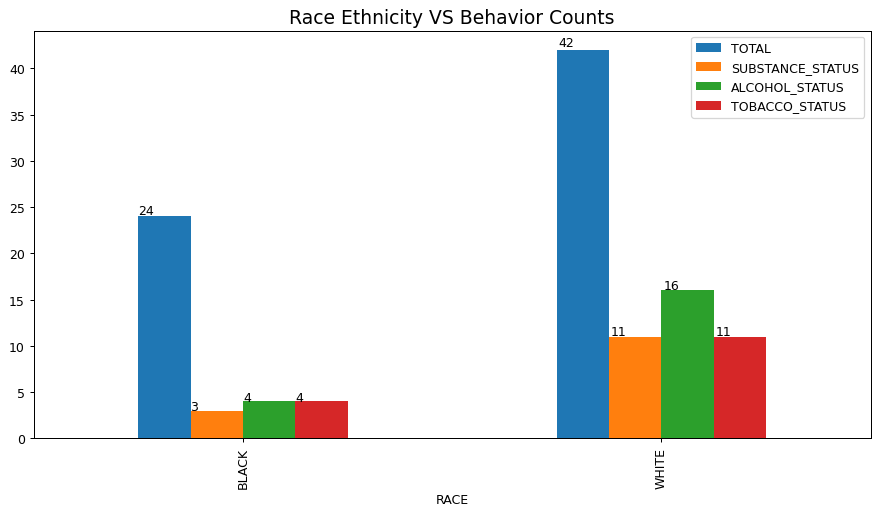

In [0]:
# plot race_behaviour dataframe.
fig, ax = plt.subplots(figsize=(12,6) ,dpi=90)
plt.title('Race Ethnicity VS Behavior Counts', size=15)
race_behaviour_df.plot(x="RACE", y=["TOTAL", "SUBSTANCE_STATUS", "ALCOHOL_STATUS", "TOBACCO_STATUS"], kind="bar", ax=ax)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

## 14. GENDER-BASED ANALYSIS

Lets make some gender based analysis.

### 14.1. GENDER-BEHAVIOUR ANALYSIS

In [0]:
insurance_risk_df.GENDER.value_counts()

Out[14]: Female     200
Unknown    122
Male       115
Name: GENDER, dtype: int64

In [0]:
gender_df = insurance_risk_df[insurance_risk_df.GENDER != "Unknown"].copy()   # drop Unknown 
gender_behaviour_df = gender_df[["GENDER", "SUBSTANCE_STATUS", "ALCOHOL_STATUS", "TOBACCO_STATUS"]]
gender_behaviour_df = gender_behaviour_df.groupby("GENDER").sum().reset_index()
gender_behaviour_df = gender_behaviour_df.merge(pd.DataFrame(gender_df.GENDER.value_counts().reset_index()).rename(columns = {"GENDER":"TOTAL", "index":"GENDER"}), on = "GENDER")
gender_behaviour_df

,GENDER,SUBSTANCE_STATUS,ALCOHOL_STATUS,TOBACCO_STATUS,TOTAL
0,Female,13,37,33,200
1,Male,13,25,39,115


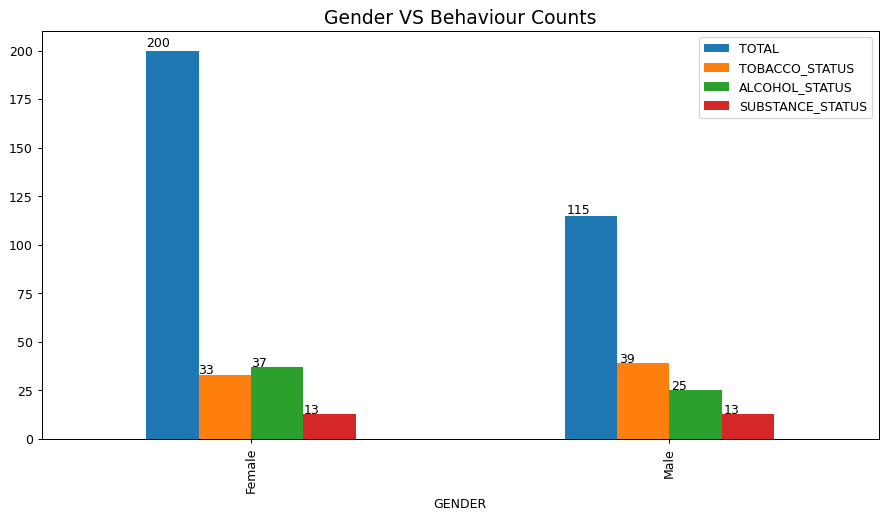

In [0]:
fig, ax = plt.subplots(figsize=(12,6) ,dpi=90)
plt.title('Gender VS Behaviour Counts', size=15)
gender_behaviour_df.plot(x="GENDER", y=["TOTAL", "TOBACCO_STATUS", "ALCOHOL_STATUS", "SUBSTANCE_STATUS"], kind="bar", ax=ax)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 14.2. OBESITY-GENDER-BEHAVIOUR ANALYSIS

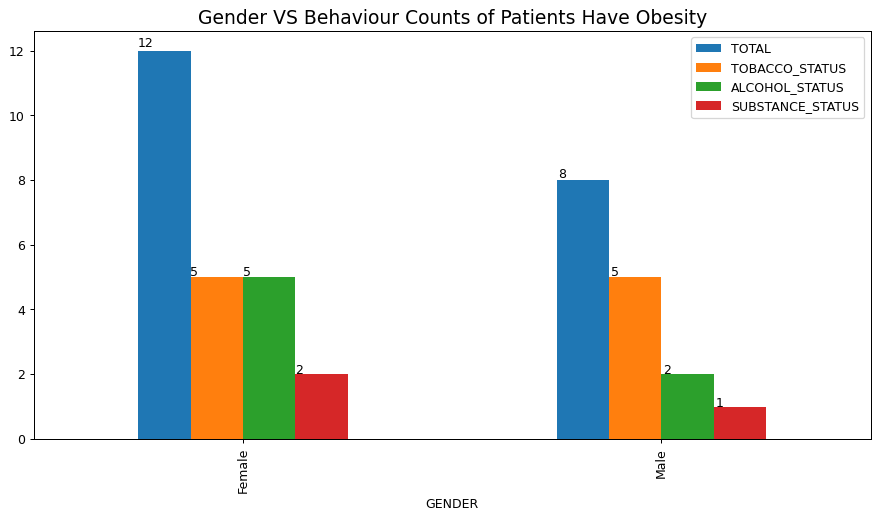

In [0]:
gender_df["DISEASE_NORMALIZED"] = get_normalized_name(gender_df, "DISEASE_ICD")
obesity_df = gender_df[gender_df.DISEASE_NORMALIZED.astype(str).str.contains("obesity")].reset_index(drop=True)

obesity_behaviour_df = obesity_df[["GENDER", "SUBSTANCE_STATUS", "ALCOHOL_STATUS", "TOBACCO_STATUS"]]
obesity_behaviour_df = obesity_behaviour_df.groupby("GENDER").sum().reset_index()
obesity_behaviour_df = obesity_behaviour_df.merge(pd.DataFrame(obesity_df.GENDER.value_counts().reset_index()).rename(columns = {"GENDER":"TOTAL", "index":"GENDER"}), on = "GENDER")

fig, ax = plt.subplots(figsize=(12,6) ,dpi=90)
plt.title('Gender VS Behaviour Counts of Patients Have Obesity', size=15)
obesity_behaviour_df.plot(x="GENDER", y=["TOTAL", "TOBACCO_STATUS", "ALCOHOL_STATUS", "SUBSTANCE_STATUS"], kind="bar", ax=ax)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

## 15. DISEASE ANALYSIS

We will analyze the disease based extractions.

### 15.1. Most Common Diseases

Lets check the most common diseases that patients have.

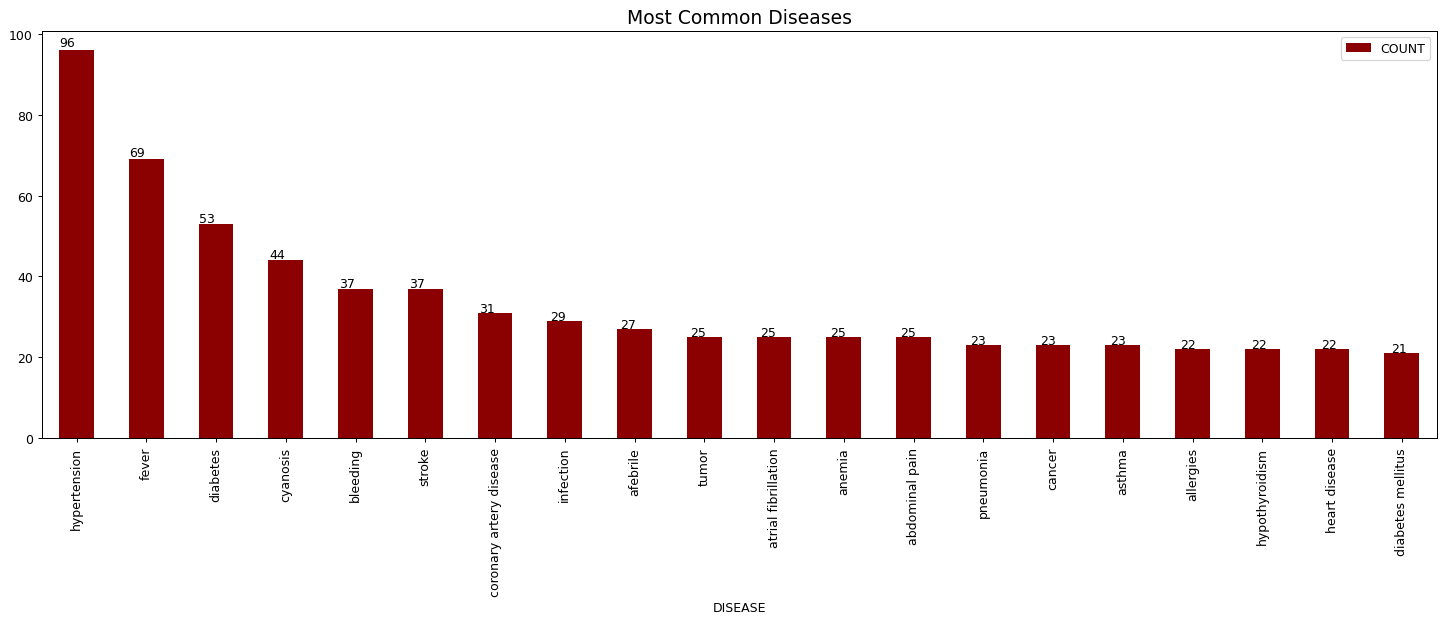

In [0]:
counts = get_occurence(insurance_risk_df, "DISEASE", 1)
top_20_disease = [(i[0][0], i[1]) for i in counts.most_common()[:20]]
top_20_disease_df = pd.DataFrame(top_20_disease, columns = ["DISEASE", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Diseases', size=15)
top_20_disease_df.plot(x="DISEASE", y=["COUNT"], kind="bar", ax=ax, color="darkred")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 15.2. Most Common Diseases With Normalized Names 

Disease extractions can have different formats, so when we will normalize the diseases by using the ICD-10-CM codes and check the most common normalized diseases and see the results will be changed.

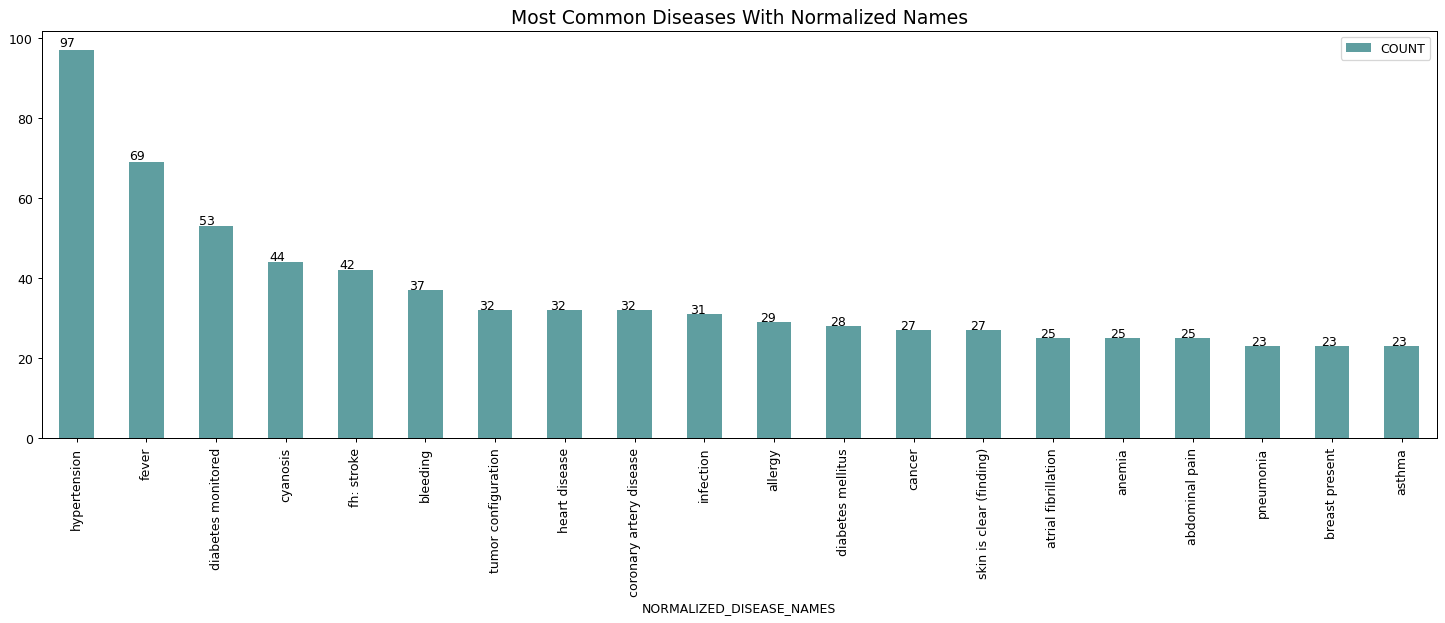

In [0]:
insurance_risk_df["DISEASE_NORMALIZED"] = get_normalized_name(insurance_risk_df, "DISEASE_ICD")
insurance_risk_df["DISEASE_NORMALIZED"] = insurance_risk_df["DISEASE_NORMALIZED"].apply(lambda x: list(set(x)))

counts = get_occurence(insurance_risk_df, "DISEASE_NORMALIZED", 1)
top_20_disease = [(i[0][0], i[1]) for i in counts.most_common()[:20]]
top_20_disease_df = pd.DataFrame(top_20_disease, columns = ["NORMALIZED_DISEASE_NAMES", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Diseases With Normalized Names', size=15)
top_20_disease_df.plot(x="NORMALIZED_DISEASE_NAMES", y=["COUNT"], kind="bar", ax=ax, color="cadetblue")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

**As you can see, some of the disease orders have been changed after normalization of the disease column.**

*NOTES:*

+ Growth hormone deficiency (GHD) is a rare and treatable condition that causes short height in children and metabolic issues in adults. 
+ FH is a genetic condition that causes high cholesterol. Familial hypercholesterolemia (FH) is a genetic disorder that affects about 1 in 250 people and increases the likelihood of having coronary heart disease at a younger age.

### 15.3. Most Common Disease Pairs

Lets check which diseases seen together in the same patient clinical note.

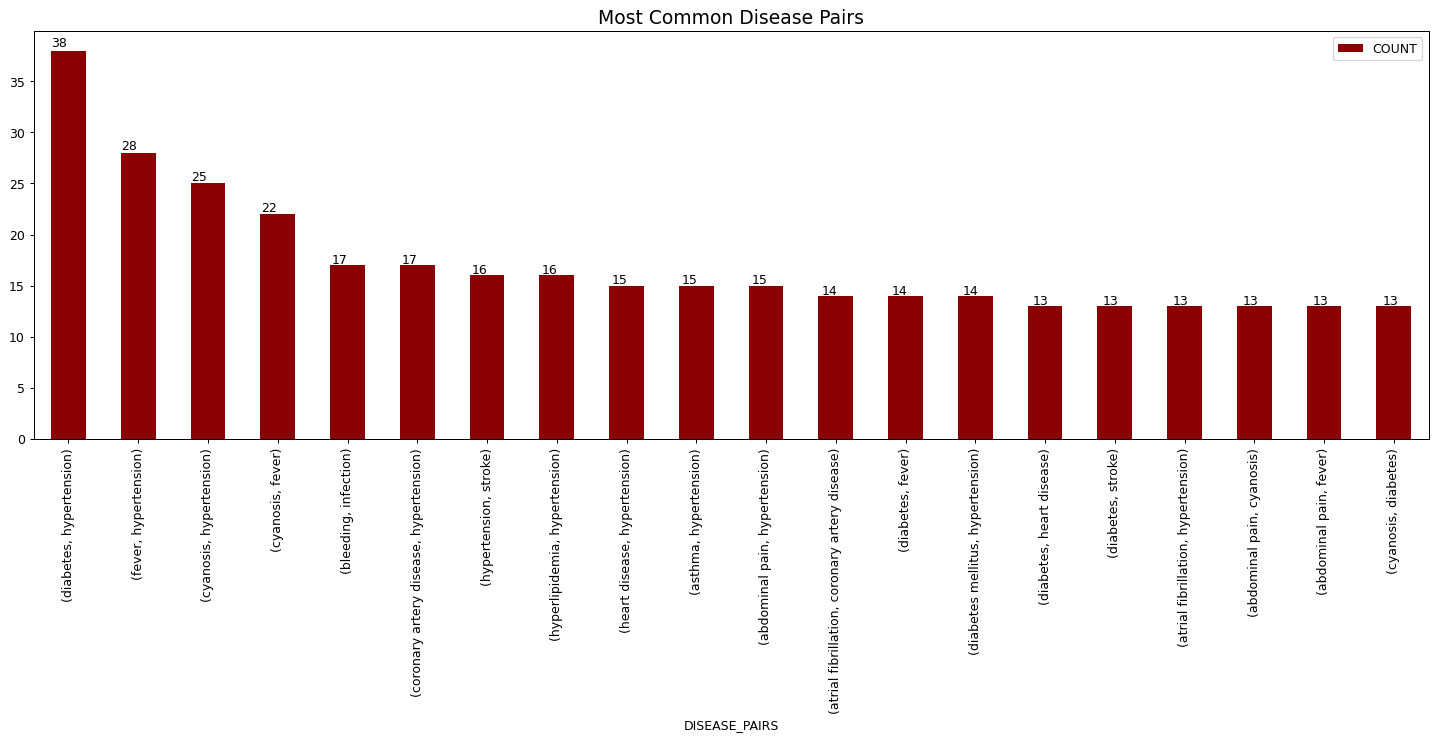

In [0]:
counts = get_occurence(insurance_risk_df, "DISEASE", 2)
top_20_disease_pairs = [(i[0], i[1]) for i in counts.most_common()[:20]]
top_20_disease_pairs_df = pd.DataFrame(top_20_disease_pairs, columns = ["DISEASE_PAIRS", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Disease Pairs', size=15)
top_20_disease_pairs_df.plot(x="DISEASE_PAIRS", y=["COUNT"], kind="bar", ax=ax, color="darkred")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 15.4. Most Common Disease Pairs With Normalized Names 

Lets check normalized disease pairs.

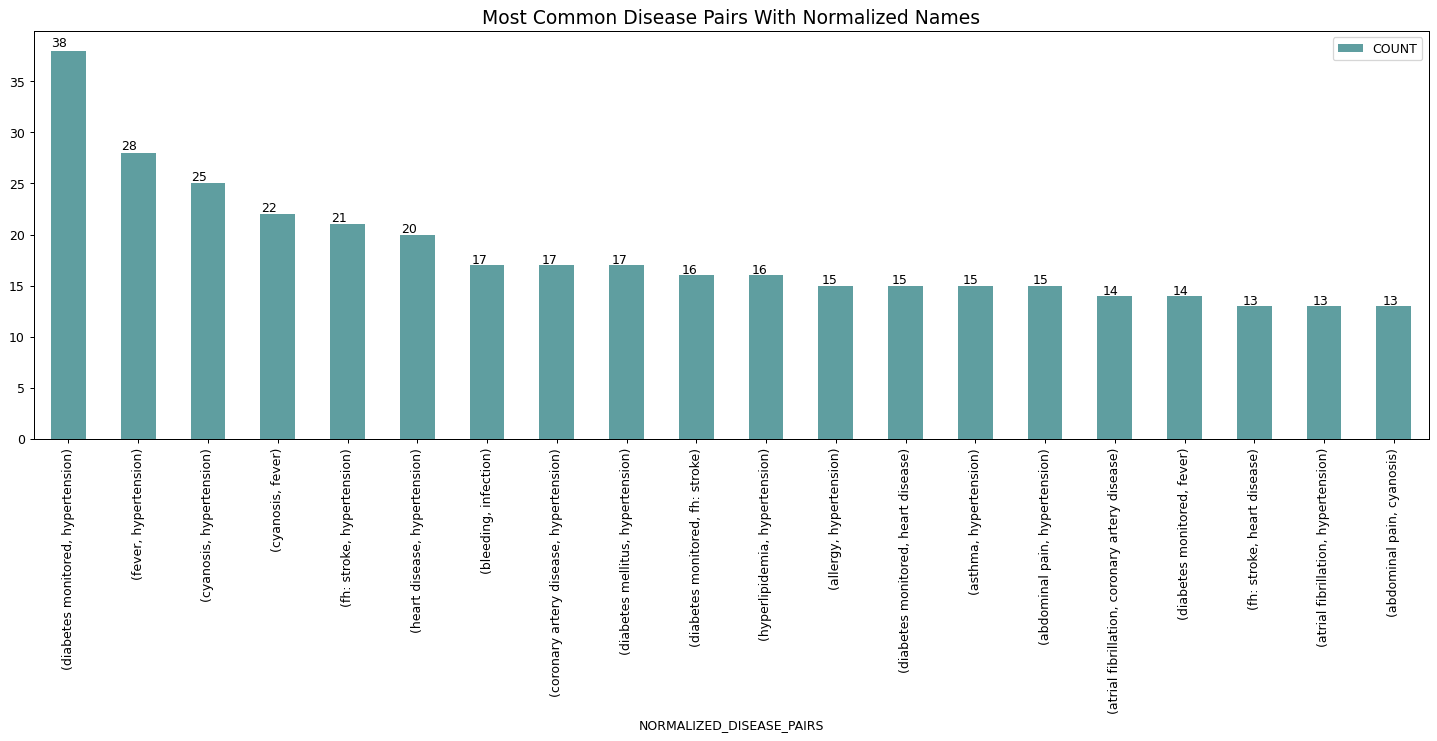

In [0]:
counts = get_occurence(insurance_risk_df, "DISEASE_NORMALIZED", 2)
top_20_disease_pairs = [(i[0], i[1]) for i in counts.most_common()[:20]]
top_20_disease_pairs_df = pd.DataFrame(top_20_disease_pairs, columns = ["NORMALIZED_DISEASE_PAIRS", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Disease Pairs With Normalized Names', size=15)
top_20_disease_pairs_df.plot(x="NORMALIZED_DISEASE_PAIRS", y=["COUNT"], kind="bar", ax=ax, color="cadetblue")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 15.5. What kind of diseases do patients who drink alcohol have?

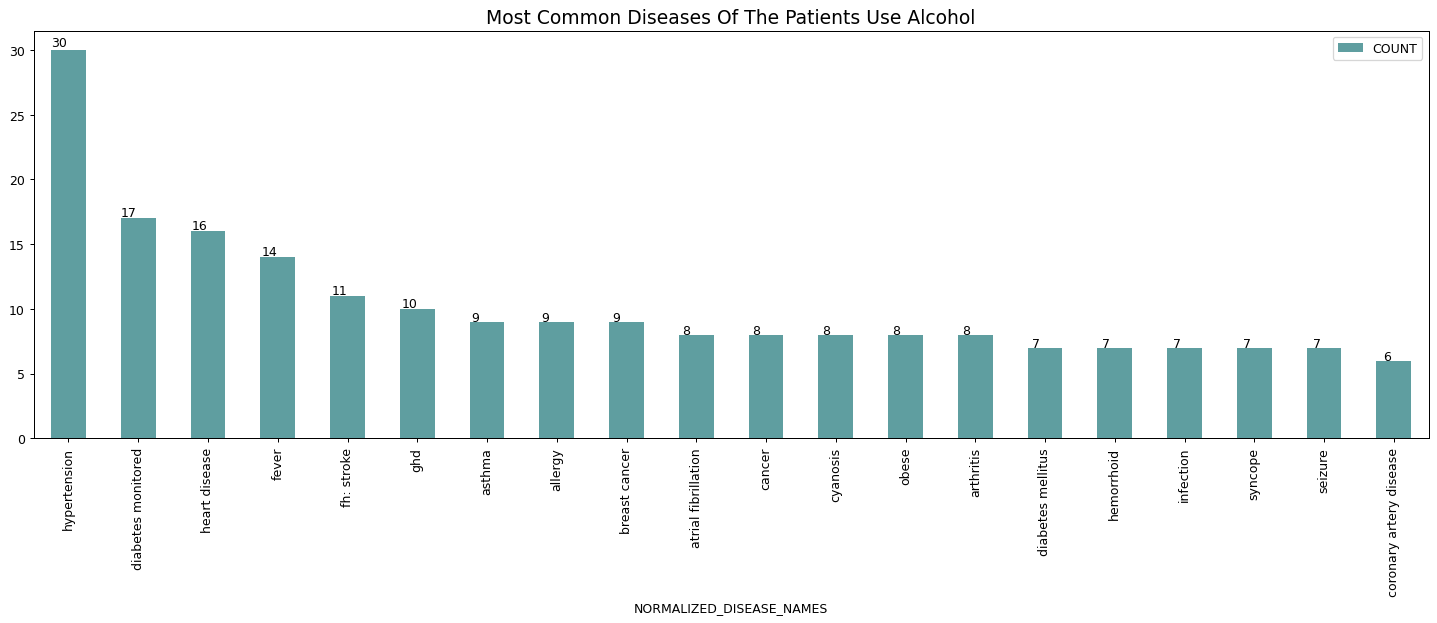

In [0]:
alcohol_df = insurance_risk_df[insurance_risk_df["ALCOHOL_STATUS"]==True]

counts = get_occurence(alcohol_df, "DISEASE_NORMALIZED", 1)
top_20_disease = [(i[0][0], i[1]) for i in counts.most_common()[:20]]
top_20_disease_df = pd.DataFrame(top_20_disease, columns = ["NORMALIZED_DISEASE_NAMES", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Diseases Of The Patients Use Alcohol', size=15)
top_20_disease_df.plot(x="NORMALIZED_DISEASE_NAMES", y=["COUNT"], kind="bar", ax=ax, color="cadetblue")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 15.6. What kind of diseases do smokers have?

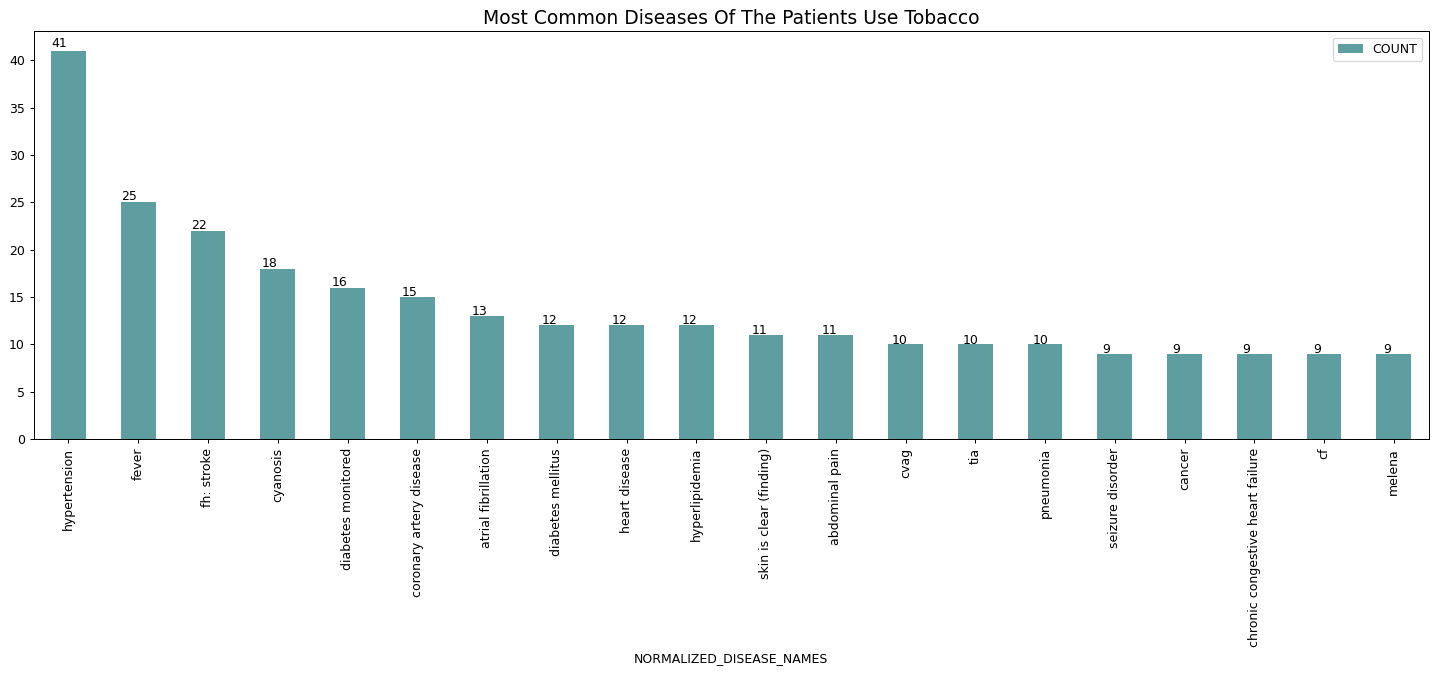

In [0]:
tobacco_df = insurance_risk_df[insurance_risk_df["TOBACCO_STATUS"]==True]

counts = get_occurence(tobacco_df, "DISEASE_NORMALIZED", 1)
top_20_disease = [(i[0][0], i[1]) for i in counts.most_common()[:20]]
top_20_disease_df = pd.DataFrame(top_20_disease, columns = ["NORMALIZED_DISEASE_NAMES", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Diseases Of The Patients Use Tobacco', size=15)
top_20_disease_df.plot(x="NORMALIZED_DISEASE_NAMES", y=["COUNT"], kind="bar", ax=ax, color="cadetblue")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

## 16. DRUG ANALYSIS

We will make analysis on the drug based extractions.

### 16.1. Most Common Used Drugs

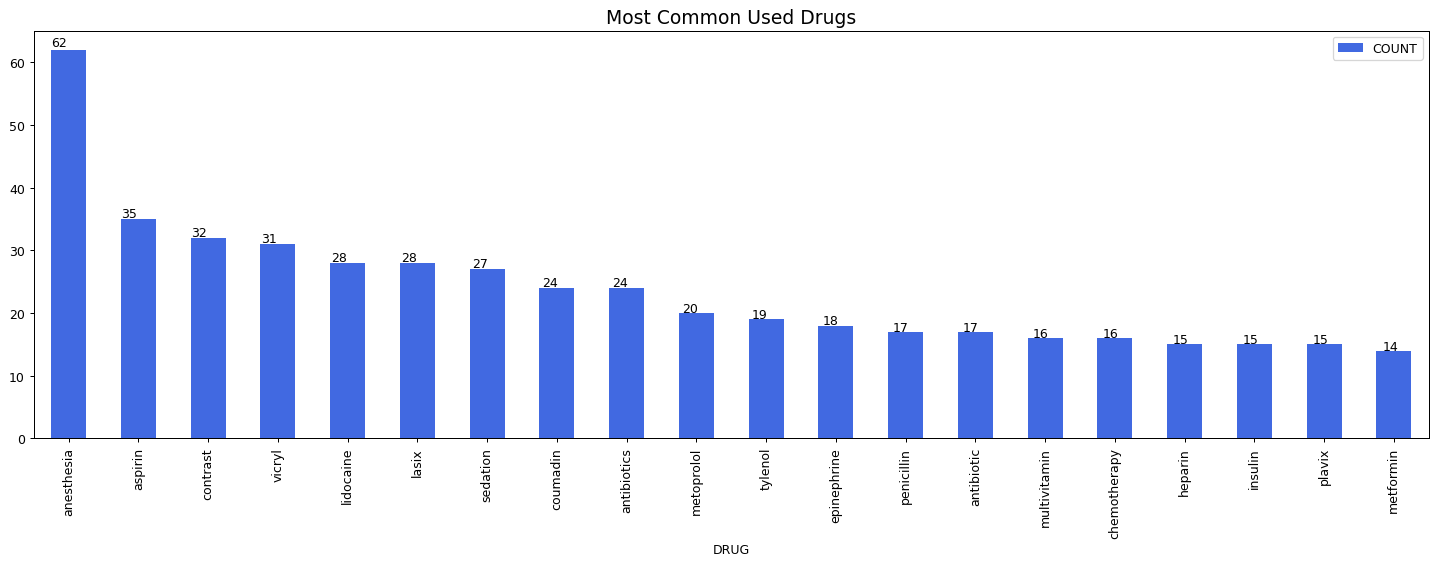

In [0]:
counts = get_occurence(insurance_risk_df, "DRUG", 1)
top_20_drug = [(i[0][0], i[1]) for i in counts.most_common()[:20]]
top_20_drug_df = pd.DataFrame(top_20_drug, columns = ["DRUG", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Used Drugs', size=15)
top_20_drug_df.plot(x="DRUG", y=["COUNT"], kind="bar", ax=ax, color="royalblue")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 16.2. Most Common Used Drugs With Normalized Names

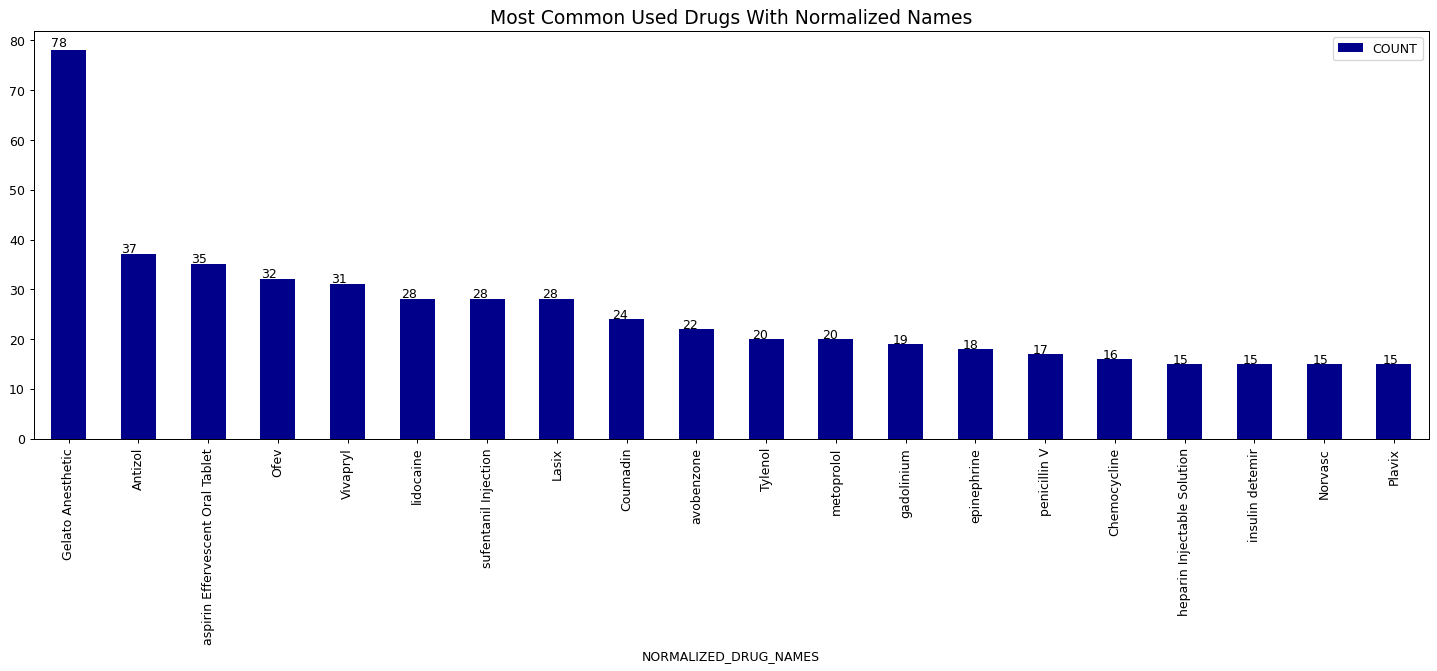

In [0]:
insurance_risk_df["DRUG_NORMALIZED"] = get_normalized_name(insurance_risk_df, "DRUG_RXNORM")
insurance_risk_df["DRUG_NORMALIZED"] = insurance_risk_df["DRUG_NORMALIZED"].apply(lambda x: list(set(x)))    # if multiple drugs have the same actions

counts = get_occurence(insurance_risk_df, "DRUG_NORMALIZED", 1)
top_20_drug = [(i[0][0], i[1]) for i in counts.most_common()[:20]]
top_20_drug_df = pd.DataFrame(top_20_drug, columns = ["NORMALIZED_DRUG_NAMES", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Used Drugs With Normalized Names', size=15)
top_20_drug_df.plot(x="NORMALIZED_DRUG_NAMES", y=["COUNT"], kind="bar", ax=ax, color="darkblue")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 16.3. Most Common Used Drug Pairs

Lets check which drugs used together by the patients.

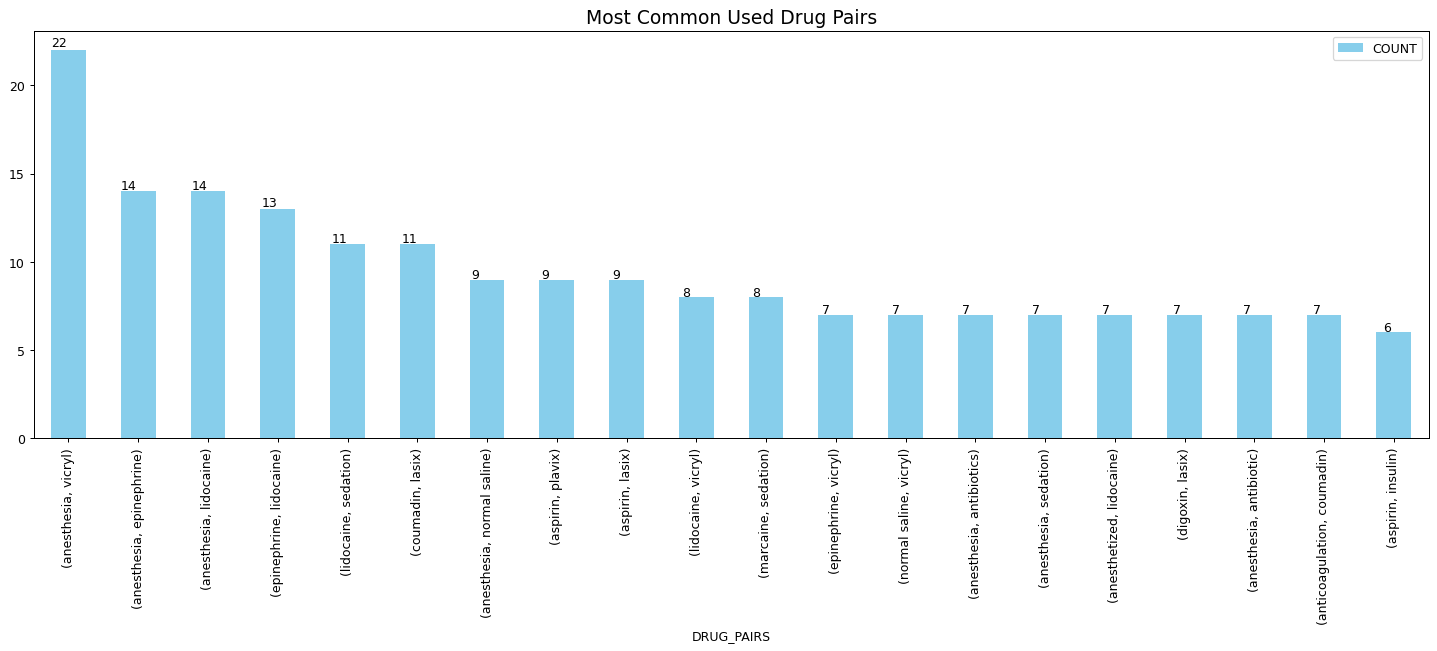

In [0]:
counts = get_occurence(insurance_risk_df, "DRUG", 2)
top_20_drug_pairs = [(i[0], i[1]) for i in counts.most_common()[:20]]
top_20_drug_pairs_df = pd.DataFrame(top_20_drug_pairs, columns = ["DRUG_PAIRS", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Used Drug Pairs', size=15)
top_20_drug_pairs_df.plot(x="DRUG_PAIRS", y=["COUNT"], kind="bar", ax=ax, color="skyblue")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 16.4. Most Common Used Drug Pairs With Normalized Names

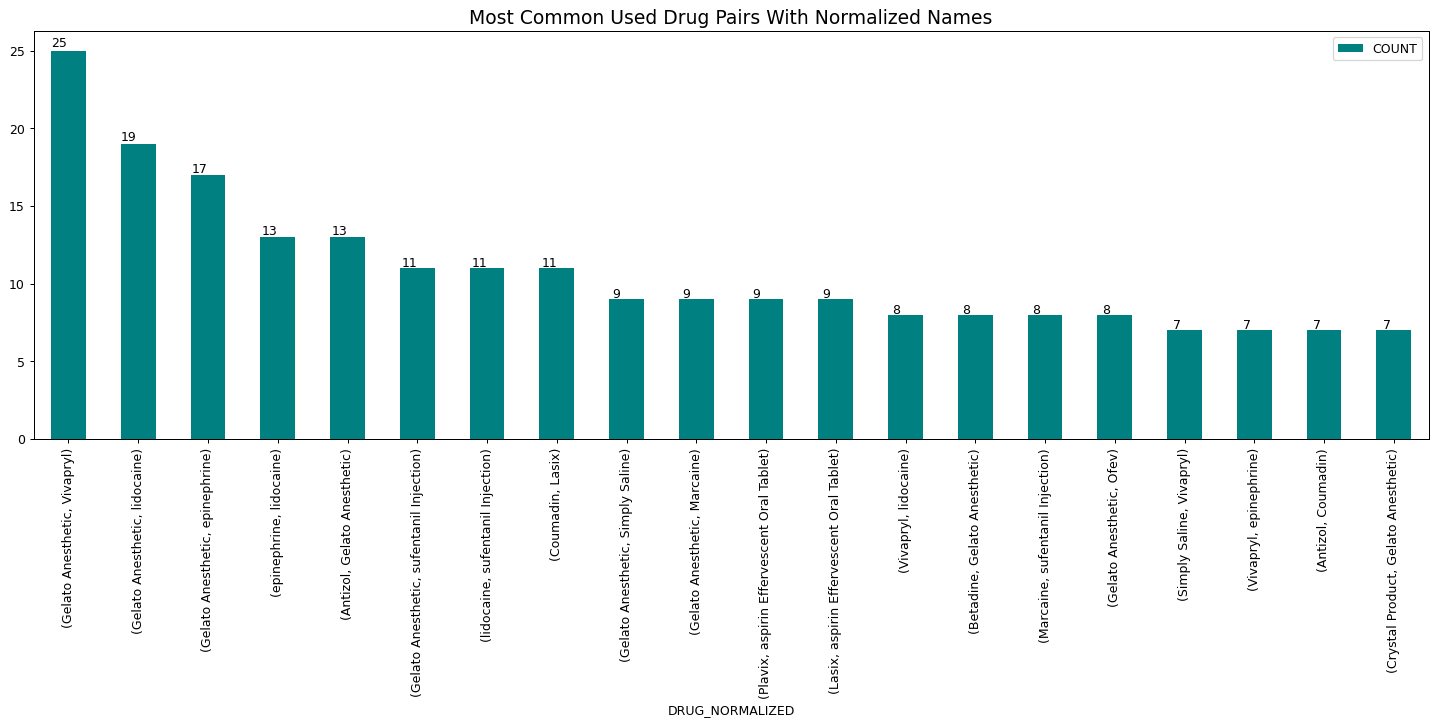

In [0]:
counts = get_occurence(insurance_risk_df, "DRUG_NORMALIZED", 2)
top_20_drug_pairs = [(i[0], i[1]) for i in counts.most_common()[:20]]
top_20_drug_pairs_df = pd.DataFrame(top_20_drug_pairs, columns = ["DRUG_NORMALIZED", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Used Drug Pairs With Normalized Names', size=15)
top_20_drug_pairs_df.plot(x="DRUG_NORMALIZED", y=["COUNT"], kind="bar", ax=ax, color="teal")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 16.5. Most Common Actions of Drugs

We will check the most comoon actions of the drugs.

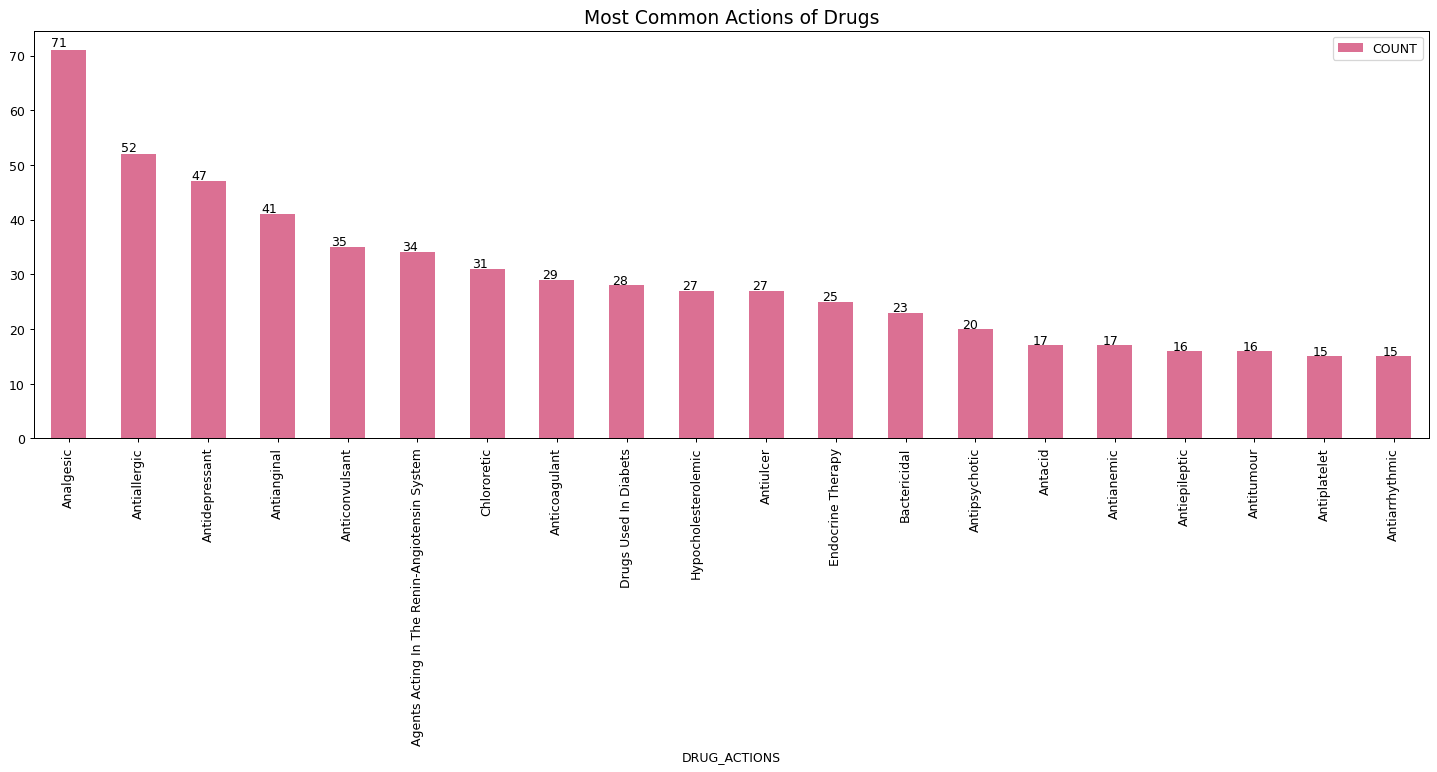

In [0]:
insurance_risk_df["DRUG_ACTIONS_NORMALIZED"] = get_normalized_name(insurance_risk_df, "DRUG_ACTIONS")
insurance_risk_df["DRUG_ACTIONS_NORMALIZED"] = insurance_risk_df["DRUG_ACTIONS_NORMALIZED"].apply(lambda x: list(set(x)))

counts = get_occurence(insurance_risk_df, "DRUG_ACTIONS_NORMALIZED", 1)
top_20_actions = [(i[0][0], i[1]) for i in counts.most_common()[:20]]
top_20_actions_df = pd.DataFrame(top_20_actions, columns = ["DRUG_ACTIONS", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Actions of Drugs', size=15)
top_20_actions_df.plot(x="DRUG_ACTIONS", y=["COUNT"], kind="bar", ax=ax, color="palevioletred")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 16.6. What kind of diseases do patients who use `Analgesic` drugs have?

As you can see, the most common drug action is `Analgesic`. Lets check what kind of diseases the patients who use `Analgesic` drugs have.

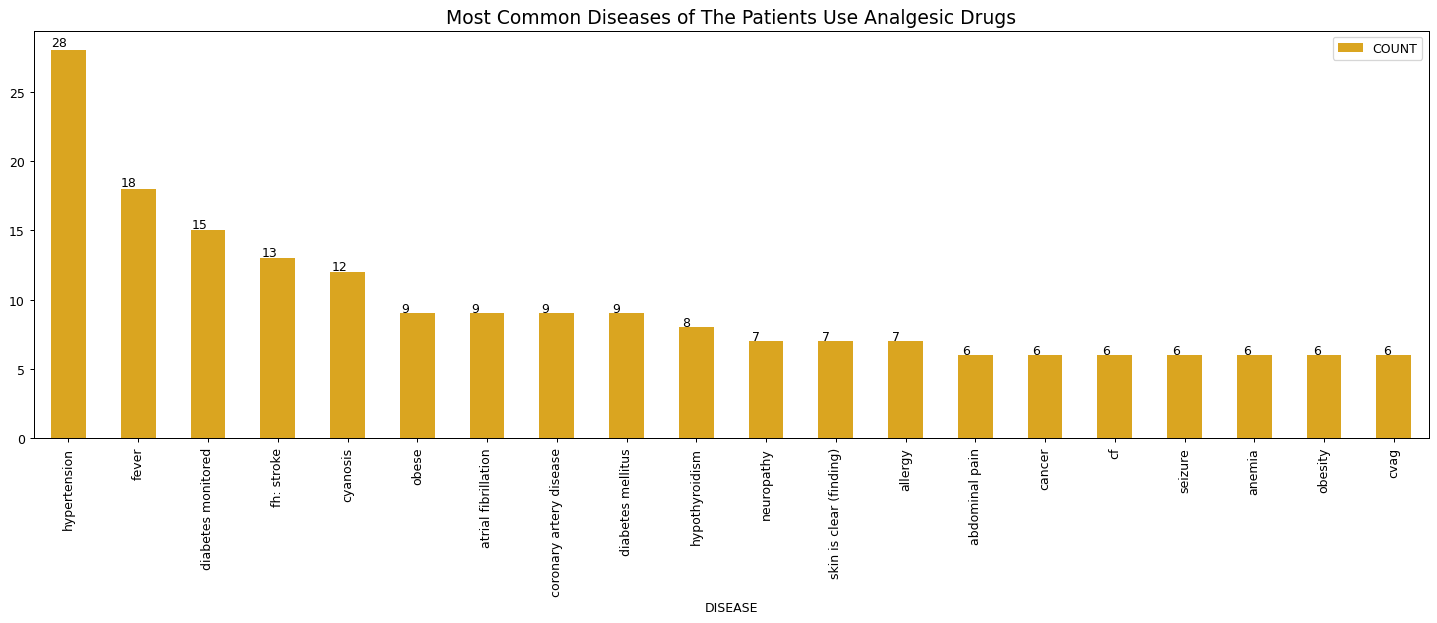

In [0]:
analgesic_df = insurance_risk_df[insurance_risk_df["DRUG_ACTIONS_NORMALIZED"].astype(str).str.contains("Analgesic")]
counts = get_occurence(analgesic_df, "DISEASE_NORMALIZED", 1)
top_20_actions = [(i[0][0], i[1]) for i in counts.most_common()[:20]]
top_20_actions_df = pd.DataFrame(top_20_actions, columns = ["DISEASE", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Diseases of The Patients Use Analgesic Drugs', size=15)
top_20_actions_df.plot(x="DISEASE", y=["COUNT"], kind="bar", ax=ax, color="goldenrod")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 16.7. What are the most common drug-action pairs?

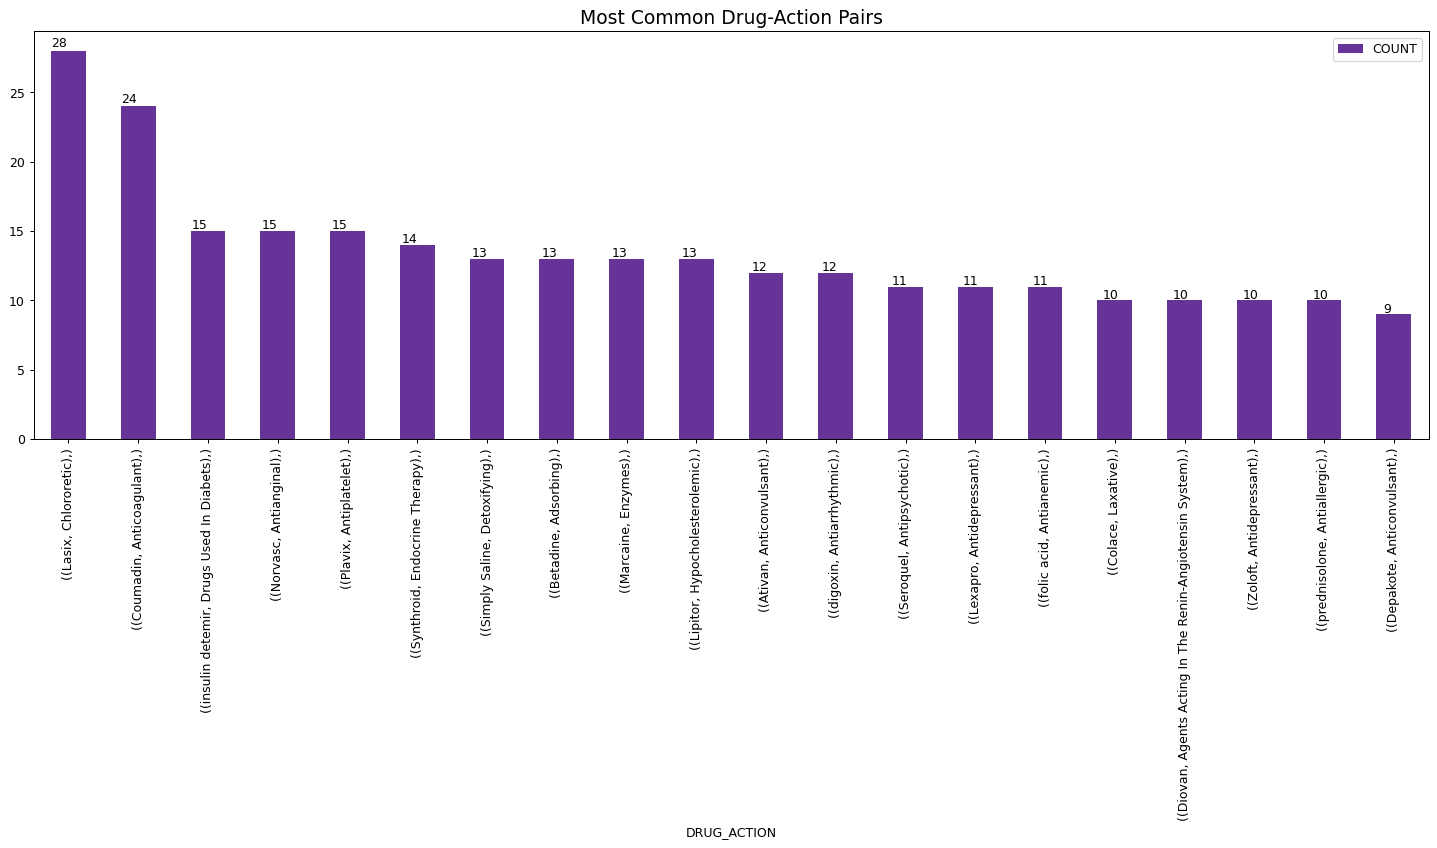

In [0]:
counts = get_occurence(insurance_risk_df, "DRUG_ACTIONS", 1)
top_20_drug_action_pairs = [(i[0], i[1]) for i in counts.most_common()[:20]]
top_20_drug_action_pairs_df = pd.DataFrame(top_20_drug_action_pairs, columns = ["DRUG_ACTION", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Drug-Action Pairs', size=15)
top_20_drug_action_pairs_df.plot(x="DRUG_ACTION", y=["COUNT"], kind="bar", ax=ax, color="rebeccapurple")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

## 17. HYPERTENSION ANALYSIS

We found that *hypertension* is the most common disease in the patient notes. Now we will create a *hypertension* sub-dataframe on the `DISEASE_NORMALIZED` column and make some analysis on this dataframe.

In [0]:
hypertension_df = insurance_risk_df.loc[insurance_risk_df.DISEASE_NORMALIZED.apply(lambda x: x if "hypertension" in x else None).dropna().index].reset_index(drop=True)

### 17.1. What are the genders of the patients have `hypertension`?

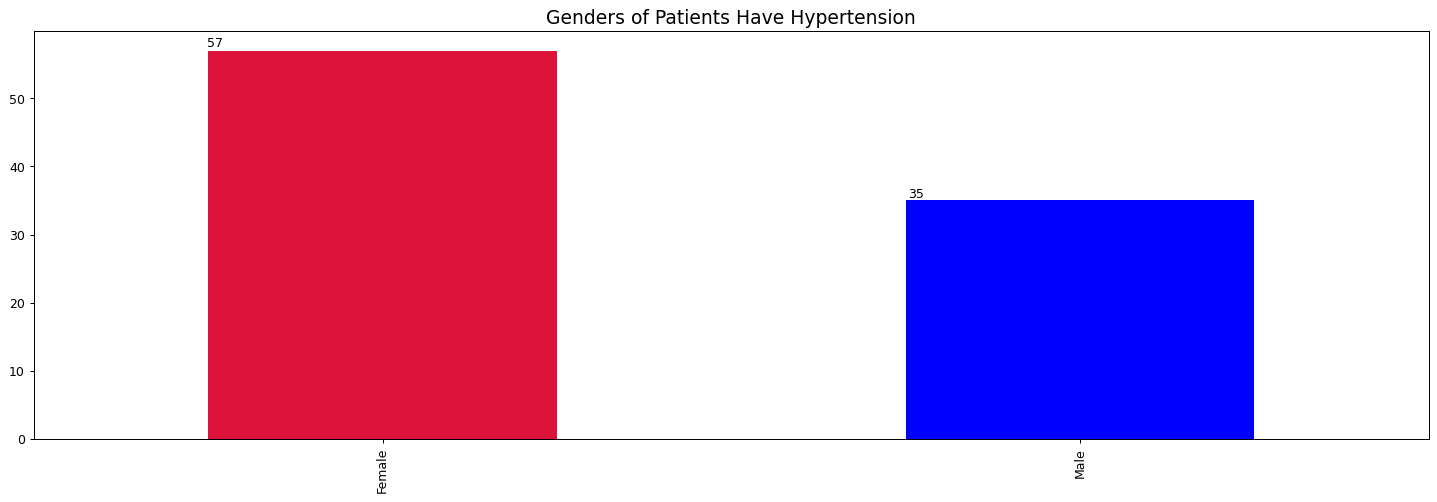

In [0]:
fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Genders of Patients Have Hypertension', size=15)
hypertension_df[hypertension_df.GENDER != "Unknown"].GENDER.value_counts().plot(kind="bar", ax=ax, color=["crimson", "blue"])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 17.2. What diseases do family members of the `hypertension` patients have?

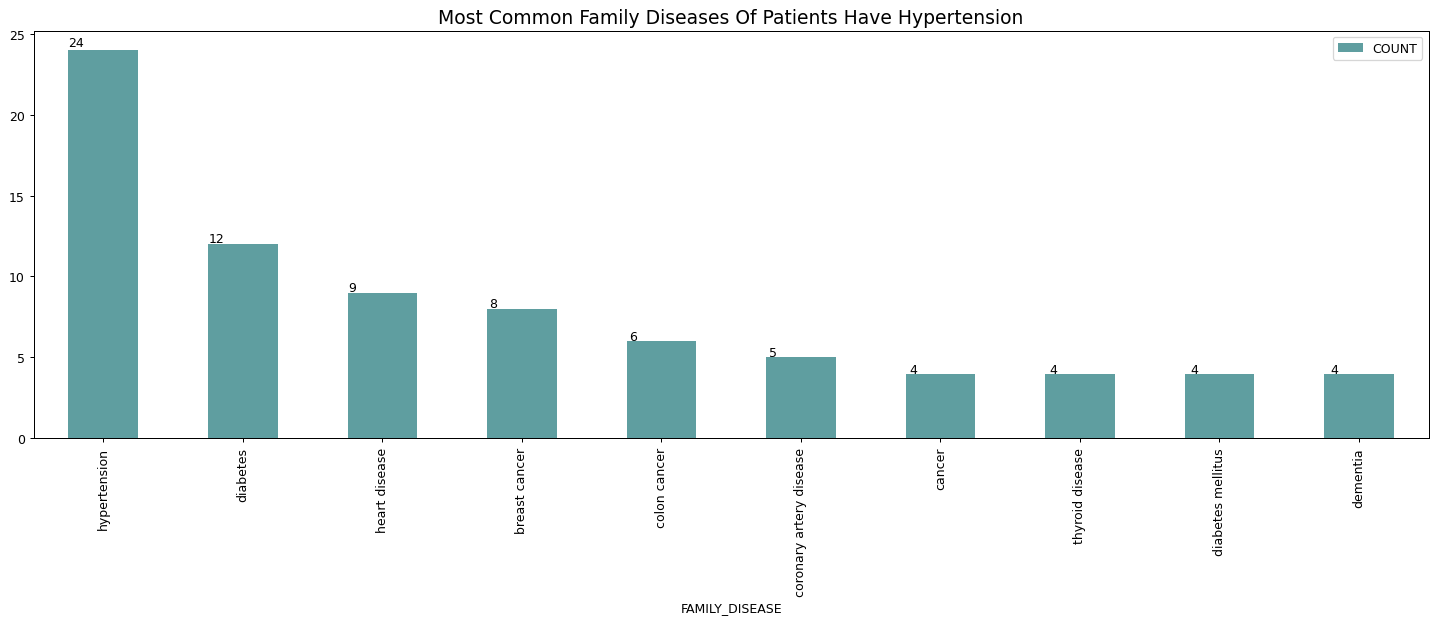

In [0]:
counts = get_occurence(hypertension_df, "FAMILY_DISEASE", 1)
top_20_disease = [(i[0][0], i[1]) for i in counts.most_common()[:10]]
top_20_disease_df = pd.DataFrame(top_20_disease, columns = ["FAMILY_DISEASE", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Family Diseases Of Patients Have Hypertension', size=15)
top_20_disease_df.plot(x="FAMILY_DISEASE", y=["COUNT"], kind="bar", ax=ax, color="cadetblue")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 17.3. What `drugs` do `hypertension` patients use?

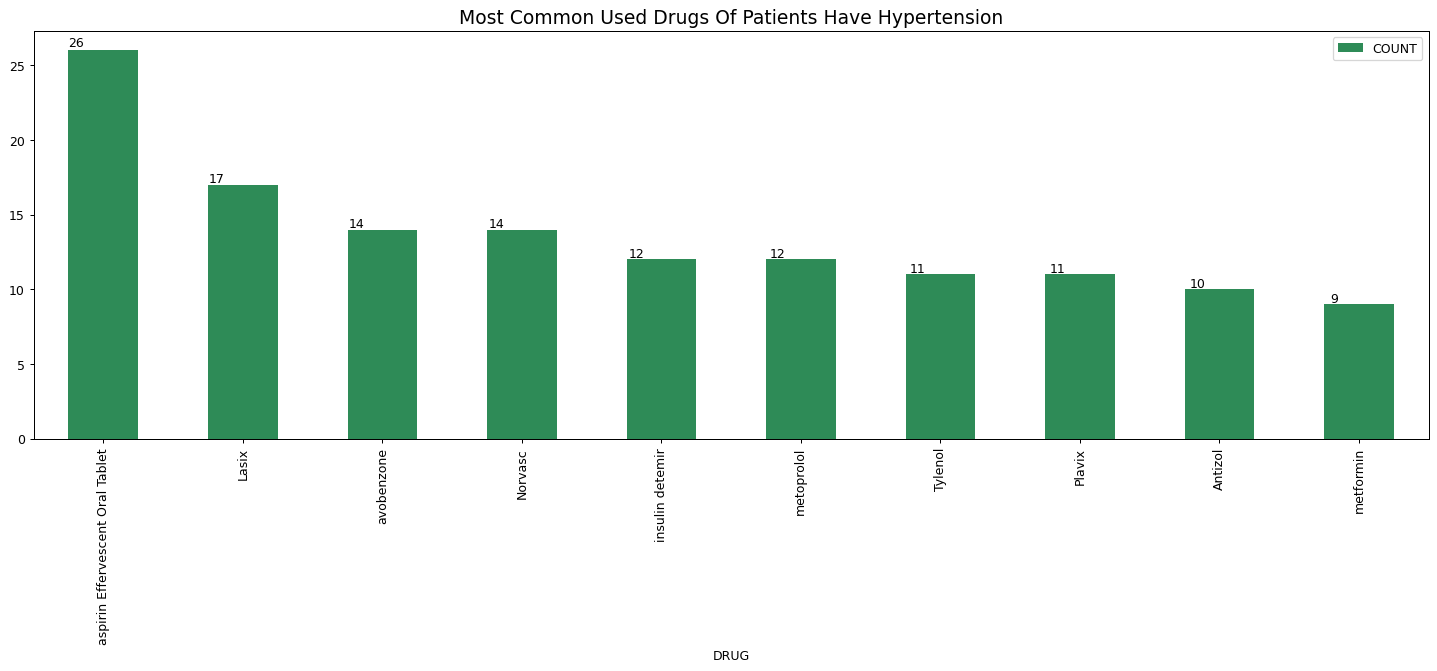

In [0]:
counts = get_occurence(hypertension_df, "DRUG_NORMALIZED", 1)
top_20_disease = [(i[0][0], i[1]) for i in counts.most_common()[:10]]
top_20_disease_df = pd.DataFrame(top_20_disease, columns = ["DRUG", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Used Drugs Of Patients Have Hypertension', size=15)
top_20_disease_df.plot(x="DRUG", y=["COUNT"], kind="bar", ax=ax, color="seagreen")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 17.4. What are the most common `actions` of the drugs that `hypertension` patients use?

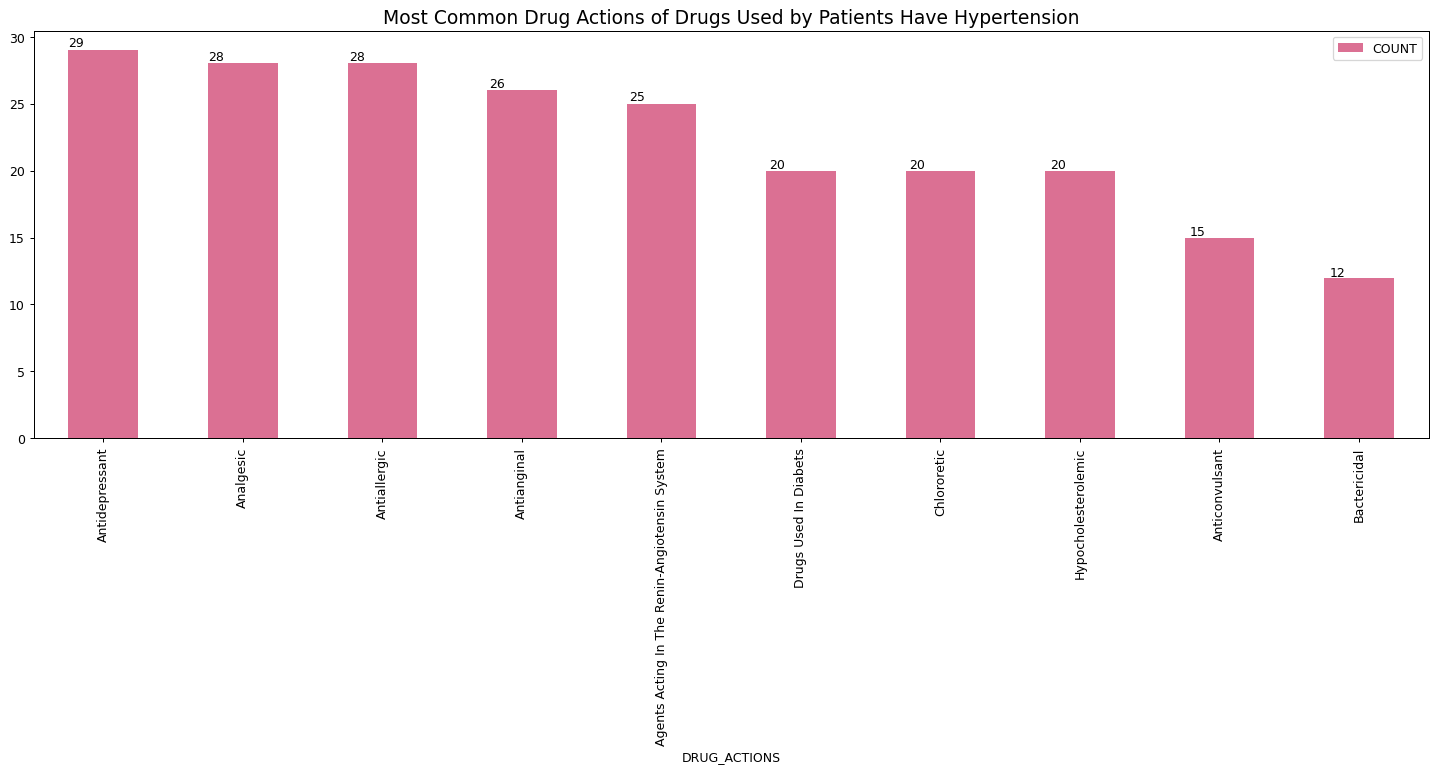

In [0]:
counts = get_occurence(hypertension_df, "DRUG_ACTIONS_NORMALIZED", 1)
top_20_disease = [(i[0][0], i[1]) for i in counts.most_common()[:10]]
top_20_disease_df = pd.DataFrame(top_20_disease, columns = ["DRUG_ACTIONS", "COUNT"])

fig, ax = plt.subplots(figsize=(20,6) ,dpi=90)
plt.title('Most Common Drug Actions of Drugs Used by Patients Have Hypertension', size=15)
top_20_disease_df.plot(x="DRUG_ACTIONS", y=["COUNT"], kind="bar", ax=ax, color="palevioletred")
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

### 17.5. Behaviours of Hypertension Patients

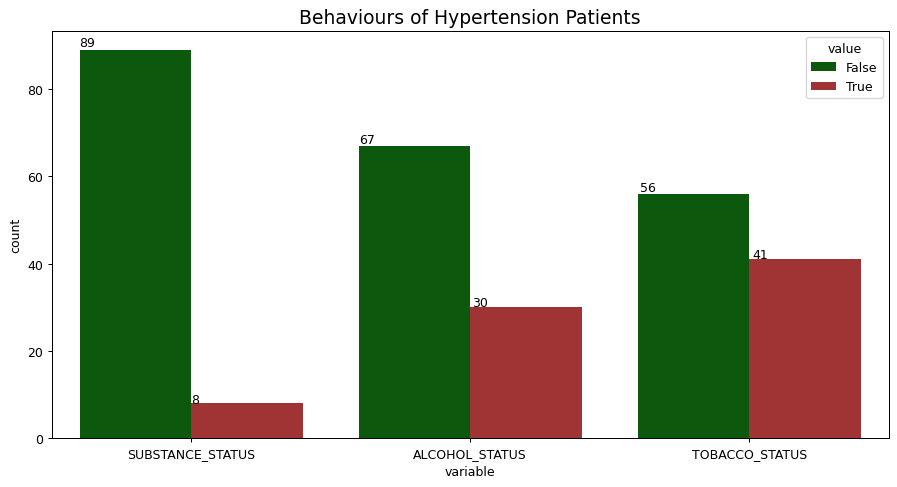

In [0]:
hypertension_behaviour_df = hypertension_df[["SUBSTANCE_STATUS", "ALCOHOL_STATUS", "TOBACCO_STATUS"]]

fig, ax = plt.subplots(figsize=(12,6) ,dpi=90)
plt.title('Behaviours of Hypertension Patients', size=15)
sns.countplot(x="variable", hue="value", data=pd.melt(hypertension_behaviour_df), palette=["darkgreen", "firebrick"])
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.show()

# License
Copyright / License info of the notebook. Copyright [2023] the Notebook Authors.  The source in this notebook is provided subject to the [Apache 2.0 License](https://spdx.org/licenses/Apache-2.0.html).  All included or referenced third party libraries are subject to the licenses set forth below.

|Library Name|Library License|Library License URL|Library Source URL|
| :-: | :-:| :-: | :-:|
|Pandas |BSD 3-Clause License| https://github.com/pandas-dev/pandas/blob/master/LICENSE | https://github.com/pandas-dev/pandas|
|Numpy |BSD 3-Clause License| https://github.com/numpy/numpy/blob/main/LICENSE.txt | https://github.com/numpy/numpy|
|Apache Spark |Apache License 2.0| https://github.com/apache/spark/blob/master/LICENSE | https://github.com/apache/spark/tree/master/python/pyspark|
|MatPlotLib | | https://github.com/matplotlib/matplotlib/blob/master/LICENSE/LICENSE | https://github.com/matplotlib/matplotlib|
|Seaborn |BSD 3-Clause License | https://github.com/seaborn/seaborn/blob/master/LICENSE | https://github.com/seaborn/seaborn/|
|Spark NLP Display|Apache License 2.0|https://github.com/JohnSnowLabs/spark-nlp-display/blob/main/LICENSE|https://github.com/JohnSnowLabs/spark-nlp-display|
|Spark NLP |Apache License 2.0| https://github.com/JohnSnowLabs/spark-nlp/blob/master/LICENSE | https://github.com/JohnSnowLabs/spark-nlp|
|Spark NLP for Healthcare|[Proprietary license - John Snow Labs Inc.](https://www.johnsnowlabs.com/spark-nlp-health/) |NA|NA|


|Author|
|-|
|Databricks Inc.|
|John Snow Labs Inc.|

# Disclaimers
Databricks Inc. (“Databricks”) does not dispense medical, diagnosis, or treatment advice. This Solution Accelerator (“tool”) is for informational purposes only and may not be used as a substitute for professional medical advice, treatment, or diagnosis. This tool may not be used within Databricks to process Protected Health Information (“PHI”) as defined in the Health Insurance Portability and Accountability Act of 1996, unless you have executed with Databricks a contract that allows for processing PHI, an accompanying Business Associate Agreement (BAA), and are running this notebook within a HIPAA Account.  Please note that if you run this notebook within Azure Databricks, your contract with Microsoft applies.